In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
path = os.path.join('..', 'Dataset\\CIFAR10')
os.listdir(path)

['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'readme.html',
 'test_batch']

In [3]:
def unpickle(path):
    with open(path, 'rb') as f:
        data = pickle._Unpickler(f)
        data.encoding = 'latin1'
        d = data.load()
    return d

In [4]:
def one_hot_encode(data, categories):
    
    val = np.eye(categories)
    return val[data]

In [5]:
def data_load():
    data = [unpickle(path + '\\data_batch_{}'.format(i)) for i in range(1, 6)]
    images = np.vstack([i['data'] for i in data])
    label = np.hstack([i['labels'] for i in data])
    images = images.reshape(images.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
    
    return images, one_hot_encode(label, 10)

In [6]:
images, label = data_load()

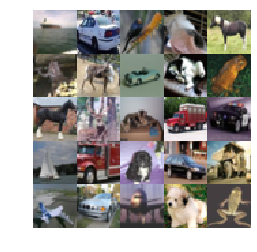

In [7]:
def display_cifar(images, size):
     n = len(images)
     plt.figure()
     plt.gca().set_axis_off()
     im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
     for i in range(size)])
     plt.imshow(im)
     plt.show()

display_cifar(images, 5)

In [8]:
def Generative_Model(x, reuse = False):
    neurons = [1024, 1024, 3072]
    with tf.variable_scope('Generative_Model', reuse = reuse) as gen:
        
        Z1 = tf.layers.dense(x, neurons[0], activation=None)
        A1 = tf.nn.leaky_relu(Z1)
        
        Z2 = tf.layers.dense(A1, neurons[2], activation = None)
        A2 = tf.nn.leaky_relu(Z2)
        
        Z3 = tf.layers.dense(A2, neurons[2], activation = None)
        A3 = tf.nn.leaky_relu(Z3)

        return A3

In [9]:
def Discriminative_Model(x, reuse):
    neurons = [1024, 1024, 1]
    with tf.variable_scope('Discriminative_Model', reuse = reuse) as dis:
        
        Z1 = tf.layers.dense(x, neurons[0], activation = None)
        A1 = tf.nn.leaky_relu(Z1)
        
        Z2 = tf.layers.dense(A1, neurons[1], activation = None)
        A2 = tf.nn.leaky_relu(Z2)
        
        Z3 = tf.layers.dense(A2, neurons[2], activation = None)
        A3 = tf.sigmoid(Z3)
        
        return Z3, A3

In [10]:
tf.reset_default_graph()

fake_images = tf.placeholder(tf.float32, (None, 3072), name = 'Fake_Input_Image')
real_images = tf.placeholder(tf.float32, (None, 3072), name = 'OriginalInputImage')

In [11]:
## Getting Input from the fake Images
fake_input = Generative_Model(fake_images, reuse = False)
# fake_input = tf.nn.tanh(fake_input)
## 
dis_real_out, dis_logits_real = Discriminative_Model(real_images, reuse = False)
dis_fake_out, dis_logits_fake = Discriminative_Model(fake_input, reuse = True)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [12]:
tf.trainable_variables()

[<tf.Variable 'Generative_Model/dense/kernel:0' shape=(3072, 1024) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_1/kernel:0' shape=(1024, 3072) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_1/bias:0' shape=(3072,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_2/kernel:0' shape=(3072, 3072) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_2/bias:0' shape=(3072,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense/kernel:0' shape=(3072, 1024) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense_1/kernel:0' shape=(1024, 1024) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense_1/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense_2/kernel:0' shape=(1024, 1) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense_2/bia

In [13]:
g_vars = [i for i in tf.trainable_variables() if 'Generative_Model' in i.name]
d_vars = [i for i in tf.trainable_variables() if 'Discriminative_Model' in i.name]

In [14]:
with tf.variable_scope('LossAndOptimization') as optimizer:
    
    optimizer = tf.train.AdamOptimizer()
    
    dis_real_label = tf.ones_like(dis_real_out)
    dis_fake_label = tf.zeros_like(dis_fake_out)
    
    dis_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_real_out, labels = dis_real_label)
    dis_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_fake_out, labels = dis_fake_label)
    
    dis_loss = tf.reduce_mean(dis_real_loss + dis_fake_loss)
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_fake_out, labels = tf.ones_like(dis_fake_out)))
    
    lr = 0.0001
    gen_step = tf.train.AdamOptimizer(lr).minimize(gen_loss, var_list = g_vars)
    dis_step = tf.train.AdamOptimizer(lr).minimize(dis_loss, var_list = d_vars)

In [18]:
epochs = 12000
batch_size = 512
gen_loss_dir = []
dis_loss_dir = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        rand_index = np.random.randint(0, images.shape[0], batch_size)
        original_image = images[rand_index].reshape(-1, 3072)
        
        random_images = np.random.uniform(-1, 1, (batch_size, 3072))

        _ = sess.run(gen_step, feed_dict = {fake_images: random_images})
        _ = sess.run(dis_step, feed_dict = {fake_images: random_images, real_images: original_image})
        
        d_loss = sess.run(dis_loss, {fake_images: random_images, real_images: original_image})
        g_loss = sess.run(gen_loss, {fake_images: random_images})

        
        print ('Iteration : {} Generative Loss: {:.4f}  Discriminative Loss: {:.4f}'.format(epoch, g_loss, d_loss))
                
        gen_loss_dir.append(g_loss)
        dis_loss_dir.append(d_loss)

    fake = sess.run(Generative_Model(fake_images, reuse = True), {fake_images: np.random.uniform(-1, 1,(25, 3072))})

Iteration : 0 Generative Loss: 0.1994  Discriminative Loss: 1.7188
Iteration : 1 Generative Loss: 0.0592  Discriminative Loss: 2.8717
Iteration : 2 Generative Loss: 0.0186  Discriminative Loss: 4.0231
Iteration : 3 Generative Loss: 0.0060  Discriminative Loss: 5.1641
Iteration : 4 Generative Loss: 0.0020  Discriminative Loss: 6.2849
Iteration : 5 Generative Loss: 0.0007  Discriminative Loss: 7.2969
Iteration : 6 Generative Loss: 0.0003  Discriminative Loss: 8.1382
Iteration : 7 Generative Loss: 0.0001  Discriminative Loss: 8.9774
Iteration : 8 Generative Loss: 0.0001  Discriminative Loss: 9.7411
Iteration : 9 Generative Loss: 0.0000  Discriminative Loss: 10.4232
Iteration : 10 Generative Loss: 0.0000  Discriminative Loss: 11.0148
Iteration : 11 Generative Loss: 0.0000  Discriminative Loss: 11.5621
Iteration : 12 Generative Loss: 0.0000  Discriminative Loss: 11.9122
Iteration : 13 Generative Loss: 0.0000  Discriminative Loss: 12.3759
Iteration : 14 Generative Loss: 0.0000  Discriminativ

Iteration : 120 Generative Loss: 0.0503  Discriminative Loss: 3.1091
Iteration : 121 Generative Loss: 0.0494  Discriminative Loss: 3.1263
Iteration : 122 Generative Loss: 0.0901  Discriminative Loss: 2.8972
Iteration : 123 Generative Loss: 0.2060  Discriminative Loss: 2.0612
Iteration : 124 Generative Loss: 0.2489  Discriminative Loss: 4.0046
Iteration : 125 Generative Loss: 0.0888  Discriminative Loss: 3.3337
Iteration : 126 Generative Loss: 0.0536  Discriminative Loss: 3.4405
Iteration : 127 Generative Loss: 0.0790  Discriminative Loss: 2.7935
Iteration : 128 Generative Loss: 0.1266  Discriminative Loss: 2.5579
Iteration : 129 Generative Loss: 0.2469  Discriminative Loss: 1.7981
Iteration : 130 Generative Loss: 0.2668  Discriminative Loss: 1.8410
Iteration : 131 Generative Loss: 0.2502  Discriminative Loss: 1.8809
Iteration : 132 Generative Loss: 0.2104  Discriminative Loss: 2.1394
Iteration : 133 Generative Loss: 0.2090  Discriminative Loss: 2.1432
Iteration : 134 Generative Loss: 0

Iteration : 240 Generative Loss: 11.4582  Discriminative Loss: 0.0004
Iteration : 241 Generative Loss: 12.5771  Discriminative Loss: 0.1085
Iteration : 242 Generative Loss: 13.0039  Discriminative Loss: 0.2607
Iteration : 243 Generative Loss: 12.1778  Discriminative Loss: 0.3897
Iteration : 244 Generative Loss: 11.7580  Discriminative Loss: 0.4920
Iteration : 245 Generative Loss: 12.1709  Discriminative Loss: 0.2366
Iteration : 246 Generative Loss: 12.9477  Discriminative Loss: 0.4600
Iteration : 247 Generative Loss: 13.7508  Discriminative Loss: 0.1443
Iteration : 248 Generative Loss: 13.7336  Discriminative Loss: 0.5807
Iteration : 249 Generative Loss: 12.9461  Discriminative Loss: 0.2889
Iteration : 250 Generative Loss: 12.5456  Discriminative Loss: 0.6852
Iteration : 251 Generative Loss: 13.1755  Discriminative Loss: 0.6287
Iteration : 252 Generative Loss: 13.4294  Discriminative Loss: 0.5310
Iteration : 253 Generative Loss: 13.2230  Discriminative Loss: 0.0828
Iteration : 254 Gene

Iteration : 359 Generative Loss: 32.0411  Discriminative Loss: 0.2878
Iteration : 360 Generative Loss: 25.3044  Discriminative Loss: 0.0678
Iteration : 361 Generative Loss: 18.1175  Discriminative Loss: 0.2391
Iteration : 362 Generative Loss: 9.9838  Discriminative Loss: 0.3459
Iteration : 363 Generative Loss: 14.6045  Discriminative Loss: 0.2360
Iteration : 364 Generative Loss: 18.0510  Discriminative Loss: 0.0408
Iteration : 365 Generative Loss: 19.6918  Discriminative Loss: 0.1143
Iteration : 366 Generative Loss: 19.4368  Discriminative Loss: 0.4422
Iteration : 367 Generative Loss: 18.1121  Discriminative Loss: 0.3189
Iteration : 368 Generative Loss: 15.7749  Discriminative Loss: 0.3262
Iteration : 369 Generative Loss: 12.0361  Discriminative Loss: 0.0142
Iteration : 370 Generative Loss: 8.7369  Discriminative Loss: 0.1211
Iteration : 371 Generative Loss: 16.8116  Discriminative Loss: 0.5004
Iteration : 372 Generative Loss: 22.9041  Discriminative Loss: 0.4851
Iteration : 373 Genera

Iteration : 477 Generative Loss: 8.6133  Discriminative Loss: 0.0018
Iteration : 478 Generative Loss: 8.3217  Discriminative Loss: 0.5474
Iteration : 479 Generative Loss: 8.4796  Discriminative Loss: 0.0471
Iteration : 480 Generative Loss: 8.1804  Discriminative Loss: 0.0018
Iteration : 481 Generative Loss: 8.3224  Discriminative Loss: 0.1103
Iteration : 482 Generative Loss: 8.0805  Discriminative Loss: 0.1770
Iteration : 483 Generative Loss: 7.9024  Discriminative Loss: 0.1198
Iteration : 484 Generative Loss: 7.9572  Discriminative Loss: 0.1727
Iteration : 485 Generative Loss: 8.0214  Discriminative Loss: 0.1365
Iteration : 486 Generative Loss: 8.4246  Discriminative Loss: 0.1488
Iteration : 487 Generative Loss: 8.5312  Discriminative Loss: 0.1703
Iteration : 488 Generative Loss: 8.2762  Discriminative Loss: 0.3010
Iteration : 489 Generative Loss: 7.9736  Discriminative Loss: 0.0972
Iteration : 490 Generative Loss: 7.6699  Discriminative Loss: 0.0255
Iteration : 491 Generative Loss: 7

Iteration : 596 Generative Loss: 8.6984  Discriminative Loss: 0.1978
Iteration : 597 Generative Loss: 7.9952  Discriminative Loss: 0.0043
Iteration : 598 Generative Loss: 7.0521  Discriminative Loss: 0.0063
Iteration : 599 Generative Loss: 6.5127  Discriminative Loss: 0.0086
Iteration : 600 Generative Loss: 6.7059  Discriminative Loss: 0.0083
Iteration : 601 Generative Loss: 7.3274  Discriminative Loss: 0.0071
Iteration : 602 Generative Loss: 7.5100  Discriminative Loss: 0.4182
Iteration : 603 Generative Loss: 7.9062  Discriminative Loss: 0.0224
Iteration : 604 Generative Loss: 7.9680  Discriminative Loss: 0.0049
Iteration : 605 Generative Loss: 7.8338  Discriminative Loss: 0.0886
Iteration : 606 Generative Loss: 7.5457  Discriminative Loss: 0.0051
Iteration : 607 Generative Loss: 6.8143  Discriminative Loss: 0.3892
Iteration : 608 Generative Loss: 6.4761  Discriminative Loss: 0.0456
Iteration : 609 Generative Loss: 6.1646  Discriminative Loss: 0.1569
Iteration : 610 Generative Loss: 6

Iteration : 714 Generative Loss: 6.8059  Discriminative Loss: 0.0812
Iteration : 715 Generative Loss: 6.0293  Discriminative Loss: 0.0220
Iteration : 716 Generative Loss: 5.7028  Discriminative Loss: 0.0848
Iteration : 717 Generative Loss: 5.6982  Discriminative Loss: 0.0172
Iteration : 718 Generative Loss: 6.3279  Discriminative Loss: 0.0399
Iteration : 719 Generative Loss: 6.8249  Discriminative Loss: 0.0726
Iteration : 720 Generative Loss: 6.9831  Discriminative Loss: 0.0097
Iteration : 721 Generative Loss: 7.4608  Discriminative Loss: 0.0102
Iteration : 722 Generative Loss: 7.5572  Discriminative Loss: 0.0547
Iteration : 723 Generative Loss: 7.4047  Discriminative Loss: 0.0120
Iteration : 724 Generative Loss: 7.1139  Discriminative Loss: 0.0417
Iteration : 725 Generative Loss: 6.5685  Discriminative Loss: 0.0303
Iteration : 726 Generative Loss: 6.0756  Discriminative Loss: 0.0613
Iteration : 727 Generative Loss: 5.6886  Discriminative Loss: 0.0210
Iteration : 728 Generative Loss: 5

Iteration : 834 Generative Loss: 5.8401  Discriminative Loss: 0.1173
Iteration : 835 Generative Loss: 6.3585  Discriminative Loss: 0.1659
Iteration : 836 Generative Loss: 6.3195  Discriminative Loss: 0.1778
Iteration : 837 Generative Loss: 6.1859  Discriminative Loss: 0.0502
Iteration : 838 Generative Loss: 5.8036  Discriminative Loss: 0.1015
Iteration : 839 Generative Loss: 5.5903  Discriminative Loss: 0.0316
Iteration : 840 Generative Loss: 5.3696  Discriminative Loss: 0.2305
Iteration : 841 Generative Loss: 5.6005  Discriminative Loss: 0.0347
Iteration : 842 Generative Loss: 5.5876  Discriminative Loss: 0.1379
Iteration : 843 Generative Loss: 5.9244  Discriminative Loss: 0.0283
Iteration : 844 Generative Loss: 6.2258  Discriminative Loss: 0.0279
Iteration : 845 Generative Loss: 6.4111  Discriminative Loss: 0.0254
Iteration : 846 Generative Loss: 6.5266  Discriminative Loss: 0.0278
Iteration : 847 Generative Loss: 6.5747  Discriminative Loss: 0.0214
Iteration : 848 Generative Loss: 6

Iteration : 953 Generative Loss: 4.9112  Discriminative Loss: 0.0843
Iteration : 954 Generative Loss: 4.5943  Discriminative Loss: 0.1273
Iteration : 955 Generative Loss: 4.2571  Discriminative Loss: 0.4019
Iteration : 956 Generative Loss: 4.1920  Discriminative Loss: 0.1182
Iteration : 957 Generative Loss: 3.9213  Discriminative Loss: 0.1386
Iteration : 958 Generative Loss: 4.2124  Discriminative Loss: 0.1279
Iteration : 959 Generative Loss: 4.0667  Discriminative Loss: 0.1211
Iteration : 960 Generative Loss: 4.2071  Discriminative Loss: 0.1650
Iteration : 961 Generative Loss: 4.3310  Discriminative Loss: 0.1109
Iteration : 962 Generative Loss: 4.2390  Discriminative Loss: 0.2540
Iteration : 963 Generative Loss: 4.3302  Discriminative Loss: 0.1384
Iteration : 964 Generative Loss: 4.2856  Discriminative Loss: 0.1287
Iteration : 965 Generative Loss: 4.2671  Discriminative Loss: 0.1395
Iteration : 966 Generative Loss: 4.0711  Discriminative Loss: 0.3491
Iteration : 967 Generative Loss: 4

Iteration : 1071 Generative Loss: 1.2612  Discriminative Loss: 0.3398
Iteration : 1072 Generative Loss: 1.2608  Discriminative Loss: 0.3395
Iteration : 1073 Generative Loss: 1.2586  Discriminative Loss: 0.3400
Iteration : 1074 Generative Loss: 1.2629  Discriminative Loss: 0.3699
Iteration : 1075 Generative Loss: 1.2811  Discriminative Loss: 0.3305
Iteration : 1076 Generative Loss: 1.2742  Discriminative Loss: 0.5091
Iteration : 1077 Generative Loss: 1.2736  Discriminative Loss: 0.3732
Iteration : 1078 Generative Loss: 1.2680  Discriminative Loss: 0.3603
Iteration : 1079 Generative Loss: 1.2683  Discriminative Loss: 0.3338
Iteration : 1080 Generative Loss: 1.2740  Discriminative Loss: 0.3318
Iteration : 1081 Generative Loss: 1.2701  Discriminative Loss: 0.3339
Iteration : 1082 Generative Loss: 1.2694  Discriminative Loss: 0.3334
Iteration : 1083 Generative Loss: 1.2643  Discriminative Loss: 0.3353
Iteration : 1084 Generative Loss: 1.2768  Discriminative Loss: 0.3302
Iteration : 1085 Gen

Iteration : 1189 Generative Loss: 1.3995  Discriminative Loss: 0.6602
Iteration : 1190 Generative Loss: 1.3689  Discriminative Loss: 0.2951
Iteration : 1191 Generative Loss: 1.3521  Discriminative Loss: 0.3011
Iteration : 1192 Generative Loss: 1.3387  Discriminative Loss: 0.3061
Iteration : 1193 Generative Loss: 1.3207  Discriminative Loss: 0.3127
Iteration : 1194 Generative Loss: 1.3147  Discriminative Loss: 0.3147
Iteration : 1195 Generative Loss: 1.3051  Discriminative Loss: 0.3184
Iteration : 1196 Generative Loss: 1.3068  Discriminative Loss: 0.3178
Iteration : 1197 Generative Loss: 1.3039  Discriminative Loss: 0.3184
Iteration : 1198 Generative Loss: 1.3114  Discriminative Loss: 0.3157
Iteration : 1199 Generative Loss: 1.3164  Discriminative Loss: 0.3137
Iteration : 1200 Generative Loss: 1.3263  Discriminative Loss: 0.4118
Iteration : 1201 Generative Loss: 1.3459  Discriminative Loss: 0.3029
Iteration : 1202 Generative Loss: 1.3680  Discriminative Loss: 0.2954
Iteration : 1203 Gen

Iteration : 1308 Generative Loss: 1.5957  Discriminative Loss: 0.2282
Iteration : 1309 Generative Loss: 1.5800  Discriminative Loss: 0.2319
Iteration : 1310 Generative Loss: 1.5820  Discriminative Loss: 0.2436
Iteration : 1311 Generative Loss: 1.6120  Discriminative Loss: 0.2236
Iteration : 1312 Generative Loss: 1.6654  Discriminative Loss: 0.2105
Iteration : 1313 Generative Loss: 1.7287  Discriminative Loss: 0.2078
Iteration : 1314 Generative Loss: 1.8051  Discriminative Loss: 0.1803
Iteration : 1315 Generative Loss: 1.8152  Discriminative Loss: 0.2496
Iteration : 1316 Generative Loss: 1.8064  Discriminative Loss: 0.1801
Iteration : 1317 Generative Loss: 1.8092  Discriminative Loss: 0.1845
Iteration : 1318 Generative Loss: 1.8074  Discriminative Loss: 0.1805
Iteration : 1319 Generative Loss: 1.7886  Discriminative Loss: 0.2086
Iteration : 1320 Generative Loss: 1.7555  Discriminative Loss: 0.1989
Iteration : 1321 Generative Loss: 1.6800  Discriminative Loss: 0.2290
Iteration : 1322 Gen

Iteration : 1427 Generative Loss: 1.3005  Discriminative Loss: 0.3226
Iteration : 1428 Generative Loss: 1.5648  Discriminative Loss: 0.2367
Iteration : 1429 Generative Loss: 1.9199  Discriminative Loss: 0.2207
Iteration : 1430 Generative Loss: 2.2778  Discriminative Loss: 0.1748
Iteration : 1431 Generative Loss: 2.2751  Discriminative Loss: 0.1268
Iteration : 1432 Generative Loss: 2.2758  Discriminative Loss: 0.1090
Iteration : 1433 Generative Loss: 2.2015  Discriminative Loss: 0.1177
Iteration : 1434 Generative Loss: 2.0625  Discriminative Loss: 0.1443
Iteration : 1435 Generative Loss: 2.0301  Discriminative Loss: 0.1414
Iteration : 1436 Generative Loss: 1.9839  Discriminative Loss: 0.2547
Iteration : 1437 Generative Loss: 1.9961  Discriminative Loss: 0.3269
Iteration : 1438 Generative Loss: 1.9415  Discriminative Loss: 0.2047
Iteration : 1439 Generative Loss: 1.9862  Discriminative Loss: 0.1613
Iteration : 1440 Generative Loss: 2.0090  Discriminative Loss: 0.2624
Iteration : 1441 Gen

Iteration : 1545 Generative Loss: 2.4624  Discriminative Loss: 0.0901
Iteration : 1546 Generative Loss: 3.4129  Discriminative Loss: 0.0345
Iteration : 1547 Generative Loss: 4.2474  Discriminative Loss: 0.0157
Iteration : 1548 Generative Loss: 5.0494  Discriminative Loss: 0.0074
Iteration : 1549 Generative Loss: 5.5598  Discriminative Loss: 0.3582
Iteration : 1550 Generative Loss: 5.3241  Discriminative Loss: 0.0631
Iteration : 1551 Generative Loss: 4.7899  Discriminative Loss: 0.0266
Iteration : 1552 Generative Loss: 4.1679  Discriminative Loss: 0.0168
Iteration : 1553 Generative Loss: 3.6163  Discriminative Loss: 0.0283
Iteration : 1554 Generative Loss: 3.0546  Discriminative Loss: 0.0491
Iteration : 1555 Generative Loss: 2.5545  Discriminative Loss: 0.0815
Iteration : 1556 Generative Loss: 2.1180  Discriminative Loss: 0.1290
Iteration : 1557 Generative Loss: 1.7941  Discriminative Loss: 0.1838
Iteration : 1558 Generative Loss: 1.5961  Discriminative Loss: 0.2299
Iteration : 1559 Gen

Iteration : 1663 Generative Loss: 3.7811  Discriminative Loss: 0.0865
Iteration : 1664 Generative Loss: 3.2381  Discriminative Loss: 0.0885
Iteration : 1665 Generative Loss: 2.6858  Discriminative Loss: 0.0766
Iteration : 1666 Generative Loss: 2.2845  Discriminative Loss: 0.1136
Iteration : 1667 Generative Loss: 1.8653  Discriminative Loss: 0.1772
Iteration : 1668 Generative Loss: 1.5032  Discriminative Loss: 0.2612
Iteration : 1669 Generative Loss: 1.3499  Discriminative Loss: 0.3164
Iteration : 1670 Generative Loss: 1.2416  Discriminative Loss: 0.3743
Iteration : 1671 Generative Loss: 1.2807  Discriminative Loss: 0.6680
Iteration : 1672 Generative Loss: 1.1656  Discriminative Loss: 0.6329
Iteration : 1673 Generative Loss: 0.5703  Discriminative Loss: 0.9410
Iteration : 1674 Generative Loss: 0.3684  Discriminative Loss: 1.3996
Iteration : 1675 Generative Loss: 0.2977  Discriminative Loss: 1.6162
Iteration : 1676 Generative Loss: 0.3506  Discriminative Loss: 1.4537
Iteration : 1677 Gen

Iteration : 1780 Generative Loss: 2.0947  Discriminative Loss: 0.1399
Iteration : 1781 Generative Loss: 2.2630  Discriminative Loss: 0.2033
Iteration : 1782 Generative Loss: 2.1565  Discriminative Loss: 0.2563
Iteration : 1783 Generative Loss: 1.8557  Discriminative Loss: 0.1821
Iteration : 1784 Generative Loss: 1.6976  Discriminative Loss: 0.2155
Iteration : 1785 Generative Loss: 1.7095  Discriminative Loss: 0.2204
Iteration : 1786 Generative Loss: 1.9116  Discriminative Loss: 0.1700
Iteration : 1787 Generative Loss: 2.1805  Discriminative Loss: 0.1776
Iteration : 1788 Generative Loss: 2.3948  Discriminative Loss: 0.2499
Iteration : 1789 Generative Loss: 2.5719  Discriminative Loss: 0.2067
Iteration : 1790 Generative Loss: 2.0424  Discriminative Loss: 0.1471
Iteration : 1791 Generative Loss: 1.6983  Discriminative Loss: 0.2150
Iteration : 1792 Generative Loss: 1.5212  Discriminative Loss: 0.2675
Iteration : 1793 Generative Loss: 1.5808  Discriminative Loss: 0.2472
Iteration : 1794 Gen

Iteration : 1898 Generative Loss: 1.3609  Discriminative Loss: 0.3056
Iteration : 1899 Generative Loss: 1.3133  Discriminative Loss: 0.3238
Iteration : 1900 Generative Loss: 1.6093  Discriminative Loss: 0.2315
Iteration : 1901 Generative Loss: 2.1443  Discriminative Loss: 0.1327
Iteration : 1902 Generative Loss: 2.8521  Discriminative Loss: 0.0630
Iteration : 1903 Generative Loss: 3.5574  Discriminative Loss: 0.0323
Iteration : 1904 Generative Loss: 4.1527  Discriminative Loss: 0.0191
Iteration : 1905 Generative Loss: 4.6739  Discriminative Loss: 0.0114
Iteration : 1906 Generative Loss: 5.0367  Discriminative Loss: 0.0083
Iteration : 1907 Generative Loss: 5.3861  Discriminative Loss: 0.0062
Iteration : 1908 Generative Loss: 5.3506  Discriminative Loss: 0.1082
Iteration : 1909 Generative Loss: 5.3180  Discriminative Loss: 0.0069
Iteration : 1910 Generative Loss: 5.2365  Discriminative Loss: 0.0077
Iteration : 1911 Generative Loss: 5.0684  Discriminative Loss: 0.0089
Iteration : 1912 Gen

Iteration : 2016 Generative Loss: 2.7995  Discriminative Loss: 0.0677
Iteration : 2017 Generative Loss: 3.0325  Discriminative Loss: 0.0867
Iteration : 2018 Generative Loss: 3.1240  Discriminative Loss: 0.1052
Iteration : 2019 Generative Loss: 3.0719  Discriminative Loss: 0.0514
Iteration : 2020 Generative Loss: 3.0710  Discriminative Loss: 0.0516
Iteration : 2021 Generative Loss: 3.1750  Discriminative Loss: 0.0472
Iteration : 2022 Generative Loss: 3.2013  Discriminative Loss: 0.0457
Iteration : 2023 Generative Loss: 3.2970  Discriminative Loss: 0.0793
Iteration : 2024 Generative Loss: 3.3930  Discriminative Loss: 0.0423
Iteration : 2025 Generative Loss: 3.3043  Discriminative Loss: 0.0570
Iteration : 2026 Generative Loss: 3.1127  Discriminative Loss: 0.0733
Iteration : 2027 Generative Loss: 2.9907  Discriminative Loss: 0.0565
Iteration : 2028 Generative Loss: 2.7903  Discriminative Loss: 0.0685
Iteration : 2029 Generative Loss: 2.7700  Discriminative Loss: 0.0701
Iteration : 2030 Gen

Iteration : 2134 Generative Loss: 3.4045  Discriminative Loss: 0.0473
Iteration : 2135 Generative Loss: 3.4709  Discriminative Loss: 0.0561
Iteration : 2136 Generative Loss: 3.4973  Discriminative Loss: 0.0466
Iteration : 2137 Generative Loss: 3.0811  Discriminative Loss: 0.0649
Iteration : 2138 Generative Loss: 2.8936  Discriminative Loss: 0.0667
Iteration : 2139 Generative Loss: 2.7411  Discriminative Loss: 0.0784
Iteration : 2140 Generative Loss: 2.7783  Discriminative Loss: 0.0747
Iteration : 2141 Generative Loss: 2.9985  Discriminative Loss: 0.0649
Iteration : 2142 Generative Loss: 3.2445  Discriminative Loss: 0.0569
Iteration : 2143 Generative Loss: 3.5846  Discriminative Loss: 0.1706
Iteration : 2144 Generative Loss: 3.2047  Discriminative Loss: 0.0510
Iteration : 2145 Generative Loss: 2.7168  Discriminative Loss: 0.1304
Iteration : 2146 Generative Loss: 2.4443  Discriminative Loss: 0.1102
Iteration : 2147 Generative Loss: 2.4657  Discriminative Loss: 0.1072
Iteration : 2148 Gen

Iteration : 2253 Generative Loss: 3.2048  Discriminative Loss: 0.0643
Iteration : 2254 Generative Loss: 3.2154  Discriminative Loss: 0.1013
Iteration : 2255 Generative Loss: 3.1832  Discriminative Loss: 0.0458
Iteration : 2256 Generative Loss: 2.9621  Discriminative Loss: 0.0790
Iteration : 2257 Generative Loss: 2.8467  Discriminative Loss: 0.0640
Iteration : 2258 Generative Loss: 2.7727  Discriminative Loss: 0.0691
Iteration : 2259 Generative Loss: 2.7268  Discriminative Loss: 0.0718
Iteration : 2260 Generative Loss: 2.7459  Discriminative Loss: 0.0794
Iteration : 2261 Generative Loss: 2.7823  Discriminative Loss: 0.0682
Iteration : 2262 Generative Loss: 2.8862  Discriminative Loss: 0.0609
Iteration : 2263 Generative Loss: 3.0156  Discriminative Loss: 0.0532
Iteration : 2264 Generative Loss: 3.1544  Discriminative Loss: 0.0793
Iteration : 2265 Generative Loss: 3.2766  Discriminative Loss: 0.0424
Iteration : 2266 Generative Loss: 3.4348  Discriminative Loss: 0.0424
Iteration : 2267 Gen

Iteration : 2371 Generative Loss: 4.4685  Discriminative Loss: 0.0879
Iteration : 2372 Generative Loss: 4.4655  Discriminative Loss: 0.1097
Iteration : 2373 Generative Loss: 3.6288  Discriminative Loss: 0.0321
Iteration : 2374 Generative Loss: 2.9126  Discriminative Loss: 0.0668
Iteration : 2375 Generative Loss: 2.5778  Discriminative Loss: 0.0944
Iteration : 2376 Generative Loss: 2.6059  Discriminative Loss: 0.0903
Iteration : 2377 Generative Loss: 3.0745  Discriminative Loss: 0.0561
Iteration : 2378 Generative Loss: 3.7497  Discriminative Loss: 0.0323
Iteration : 2379 Generative Loss: 4.5243  Discriminative Loss: 0.4023
Iteration : 2380 Generative Loss: 1.3237  Discriminative Loss: 0.3661
Iteration : 2381 Generative Loss: 0.4225  Discriminative Loss: 1.2749
Iteration : 2382 Generative Loss: 0.5949  Discriminative Loss: 0.9496
Iteration : 2383 Generative Loss: 2.1306  Discriminative Loss: 0.1488
Iteration : 2384 Generative Loss: 4.6844  Discriminative Loss: 0.0127
Iteration : 2385 Gen

Iteration : 2489 Generative Loss: 0.6212  Discriminative Loss: 1.4938
Iteration : 2490 Generative Loss: 0.2531  Discriminative Loss: 2.7905
Iteration : 2491 Generative Loss: 0.1291  Discriminative Loss: 3.9527
Iteration : 2492 Generative Loss: 0.1087  Discriminative Loss: 4.4360
Iteration : 2493 Generative Loss: 0.1054  Discriminative Loss: 4.1355
Iteration : 2494 Generative Loss: 0.1296  Discriminative Loss: 3.5074
Iteration : 2495 Generative Loss: 0.2129  Discriminative Loss: 2.7549
Iteration : 2496 Generative Loss: 0.4367  Discriminative Loss: 1.6530
Iteration : 2497 Generative Loss: 1.3553  Discriminative Loss: 0.6514
Iteration : 2498 Generative Loss: 2.5636  Discriminative Loss: 0.3567
Iteration : 2499 Generative Loss: 3.9623  Discriminative Loss: 0.7022
Iteration : 2500 Generative Loss: 4.7242  Discriminative Loss: 2.2598
Iteration : 2501 Generative Loss: 3.9676  Discriminative Loss: 2.4263
Iteration : 2502 Generative Loss: 2.3220  Discriminative Loss: 0.6877
Iteration : 2503 Gen

Iteration : 2607 Generative Loss: 0.0576  Discriminative Loss: 5.3920
Iteration : 2608 Generative Loss: 0.0750  Discriminative Loss: 4.6621
Iteration : 2609 Generative Loss: 0.1554  Discriminative Loss: 3.2675
Iteration : 2610 Generative Loss: 0.2544  Discriminative Loss: 2.2848
Iteration : 2611 Generative Loss: 0.5098  Discriminative Loss: 1.2744
Iteration : 2612 Generative Loss: 1.0756  Discriminative Loss: 0.5294
Iteration : 2613 Generative Loss: 1.8898  Discriminative Loss: 10.3764
Iteration : 2614 Generative Loss: 0.1816  Discriminative Loss: 2.6741
Iteration : 2615 Generative Loss: 0.0301  Discriminative Loss: 6.2456
Iteration : 2616 Generative Loss: 0.0075  Discriminative Loss: 9.0111
Iteration : 2617 Generative Loss: 0.0018  Discriminative Loss: 11.6377
Iteration : 2618 Generative Loss: 0.0010  Discriminative Loss: 13.6868
Iteration : 2619 Generative Loss: 0.0004  Discriminative Loss: 15.8227
Iteration : 2620 Generative Loss: 0.0001  Discriminative Loss: 17.6175
Iteration : 262

Iteration : 2724 Generative Loss: 0.0018  Discriminative Loss: 9.4515
Iteration : 2725 Generative Loss: 0.0078  Discriminative Loss: 7.1692
Iteration : 2726 Generative Loss: 0.0289  Discriminative Loss: 5.1242
Iteration : 2727 Generative Loss: 0.1273  Discriminative Loss: 3.2824
Iteration : 2728 Generative Loss: 0.5642  Discriminative Loss: 1.4066
Iteration : 2729 Generative Loss: 1.6418  Discriminative Loss: 0.3893
Iteration : 2730 Generative Loss: 3.2538  Discriminative Loss: 0.0675
Iteration : 2731 Generative Loss: 4.9600  Discriminative Loss: 0.0112
Iteration : 2732 Generative Loss: 6.4746  Discriminative Loss: 0.0028
Iteration : 2733 Generative Loss: 7.6497  Discriminative Loss: 0.1683
Iteration : 2734 Generative Loss: 8.6295  Discriminative Loss: 4.5330
Iteration : 2735 Generative Loss: 6.9529  Discriminative Loss: 0.0612
Iteration : 2736 Generative Loss: 5.4109  Discriminative Loss: 0.0255
Iteration : 2737 Generative Loss: 4.0763  Discriminative Loss: 0.0521
Iteration : 2738 Gen

Iteration : 2843 Generative Loss: 0.0264  Discriminative Loss: 8.4808
Iteration : 2844 Generative Loss: 0.0283  Discriminative Loss: 9.0266
Iteration : 2845 Generative Loss: 0.0449  Discriminative Loss: 8.3779
Iteration : 2846 Generative Loss: 0.1065  Discriminative Loss: 6.5707
Iteration : 2847 Generative Loss: 0.3657  Discriminative Loss: 4.3442
Iteration : 2848 Generative Loss: 1.2348  Discriminative Loss: 1.6459
Iteration : 2849 Generative Loss: 3.9197  Discriminative Loss: 0.2244
Iteration : 2850 Generative Loss: 6.9685  Discriminative Loss: 0.0179
Iteration : 2851 Generative Loss: 10.1683  Discriminative Loss: 0.0015
Iteration : 2852 Generative Loss: 12.7529  Discriminative Loss: 0.0001
Iteration : 2853 Generative Loss: 14.4557  Discriminative Loss: 0.0000
Iteration : 2854 Generative Loss: 15.9095  Discriminative Loss: 0.0000
Iteration : 2855 Generative Loss: 17.1520  Discriminative Loss: 0.0000
Iteration : 2856 Generative Loss: 17.3477  Discriminative Loss: 0.0119
Iteration : 28

Iteration : 2961 Generative Loss: 4.0598  Discriminative Loss: 0.2238
Iteration : 2962 Generative Loss: 3.7343  Discriminative Loss: 0.1631
Iteration : 2963 Generative Loss: 3.5434  Discriminative Loss: 0.0859
Iteration : 2964 Generative Loss: 3.5011  Discriminative Loss: 0.1633
Iteration : 2965 Generative Loss: 3.4524  Discriminative Loss: 0.1216
Iteration : 2966 Generative Loss: 3.2829  Discriminative Loss: 0.1133
Iteration : 2967 Generative Loss: 3.1375  Discriminative Loss: 0.1333
Iteration : 2968 Generative Loss: 3.1199  Discriminative Loss: 0.1830
Iteration : 2969 Generative Loss: 2.9977  Discriminative Loss: 0.1879
Iteration : 2970 Generative Loss: 3.0146  Discriminative Loss: 0.1423
Iteration : 2971 Generative Loss: 3.2549  Discriminative Loss: 0.1840
Iteration : 2972 Generative Loss: 3.5337  Discriminative Loss: 0.2549
Iteration : 2973 Generative Loss: 3.3105  Discriminative Loss: 0.1867
Iteration : 2974 Generative Loss: 2.8690  Discriminative Loss: 0.1485
Iteration : 2975 Gen

Iteration : 3079 Generative Loss: 0.0002  Discriminative Loss: 38.0064
Iteration : 3080 Generative Loss: 0.0000  Discriminative Loss: 43.3406
Iteration : 3081 Generative Loss: 0.0000  Discriminative Loss: 45.3766
Iteration : 3082 Generative Loss: 0.0007  Discriminative Loss: 46.2163
Iteration : 3083 Generative Loss: 0.0000  Discriminative Loss: 47.9496
Iteration : 3084 Generative Loss: 0.0001  Discriminative Loss: 47.1140
Iteration : 3085 Generative Loss: 0.0000  Discriminative Loss: 43.7801
Iteration : 3086 Generative Loss: 0.0000  Discriminative Loss: 41.6730
Iteration : 3087 Generative Loss: 0.0000  Discriminative Loss: 38.4511
Iteration : 3088 Generative Loss: 0.0000  Discriminative Loss: 33.9390
Iteration : 3089 Generative Loss: 0.0000  Discriminative Loss: 29.4295
Iteration : 3090 Generative Loss: 0.0001  Discriminative Loss: 23.6606
Iteration : 3091 Generative Loss: 0.0007  Discriminative Loss: 18.2948
Iteration : 3092 Generative Loss: 0.0059  Discriminative Loss: 11.6493
Iterat

Iteration : 3196 Generative Loss: 0.0228  Discriminative Loss: 7.2965
Iteration : 3197 Generative Loss: 0.0250  Discriminative Loss: 8.1436
Iteration : 3198 Generative Loss: 0.0163  Discriminative Loss: 8.8226
Iteration : 3199 Generative Loss: 0.0133  Discriminative Loss: 8.9150
Iteration : 3200 Generative Loss: 0.0168  Discriminative Loss: 8.0216
Iteration : 3201 Generative Loss: 0.0311  Discriminative Loss: 7.1841
Iteration : 3202 Generative Loss: 0.0524  Discriminative Loss: 5.7754
Iteration : 3203 Generative Loss: 0.0943  Discriminative Loss: 4.4759
Iteration : 3204 Generative Loss: 0.2257  Discriminative Loss: 2.8081
Iteration : 3205 Generative Loss: 0.6742  Discriminative Loss: 1.2126
Iteration : 3206 Generative Loss: 1.7194  Discriminative Loss: 0.2752
Iteration : 3207 Generative Loss: 3.3902  Discriminative Loss: 0.0563
Iteration : 3208 Generative Loss: 4.9946  Discriminative Loss: 0.0161
Iteration : 3209 Generative Loss: 6.2885  Discriminative Loss: 0.0101
Iteration : 3210 Gen

Iteration : 3313 Generative Loss: 5.4948  Discriminative Loss: 0.0098
Iteration : 3314 Generative Loss: 5.4479  Discriminative Loss: 0.0109
Iteration : 3315 Generative Loss: 5.1835  Discriminative Loss: 0.0125
Iteration : 3316 Generative Loss: 5.0239  Discriminative Loss: 0.0341
Iteration : 3317 Generative Loss: 4.7868  Discriminative Loss: 0.0836
Iteration : 3318 Generative Loss: 4.4966  Discriminative Loss: 0.1710
Iteration : 3319 Generative Loss: 3.9321  Discriminative Loss: 0.0507
Iteration : 3320 Generative Loss: 3.2320  Discriminative Loss: 0.0714
Iteration : 3321 Generative Loss: 2.5734  Discriminative Loss: 0.1211
Iteration : 3322 Generative Loss: 2.0371  Discriminative Loss: 0.1986
Iteration : 3323 Generative Loss: 1.5744  Discriminative Loss: 0.3116
Iteration : 3324 Generative Loss: 1.2358  Discriminative Loss: 0.4460
Iteration : 3325 Generative Loss: 1.0192  Discriminative Loss: 0.5853
Iteration : 3326 Generative Loss: 0.8625  Discriminative Loss: 0.7126
Iteration : 3327 Gen

Iteration : 3432 Generative Loss: 2.8595  Discriminative Loss: 0.0773
Iteration : 3433 Generative Loss: 3.5036  Discriminative Loss: 0.1915
Iteration : 3434 Generative Loss: 3.5137  Discriminative Loss: 0.0946
Iteration : 3435 Generative Loss: 3.4867  Discriminative Loss: 0.0642
Iteration : 3436 Generative Loss: 3.2679  Discriminative Loss: 0.0528
Iteration : 3437 Generative Loss: 3.2769  Discriminative Loss: 0.0527
Iteration : 3438 Generative Loss: 3.2516  Discriminative Loss: 0.0596
Iteration : 3439 Generative Loss: 3.2831  Discriminative Loss: 0.0899
Iteration : 3440 Generative Loss: 3.4931  Discriminative Loss: 0.0459
Iteration : 3441 Generative Loss: 3.5544  Discriminative Loss: 0.1030
Iteration : 3442 Generative Loss: 3.6340  Discriminative Loss: 0.0874
Iteration : 3443 Generative Loss: 3.6955  Discriminative Loss: 0.0534
Iteration : 3444 Generative Loss: 2.9983  Discriminative Loss: 0.1118
Iteration : 3445 Generative Loss: 2.5739  Discriminative Loss: 0.1394
Iteration : 3446 Gen

Iteration : 3549 Generative Loss: 2.1251  Discriminative Loss: 0.1962
Iteration : 3550 Generative Loss: 2.4078  Discriminative Loss: 0.1476
Iteration : 3551 Generative Loss: 3.1761  Discriminative Loss: 0.0590
Iteration : 3552 Generative Loss: 4.1186  Discriminative Loss: 0.0214
Iteration : 3553 Generative Loss: 4.9645  Discriminative Loss: 0.0532
Iteration : 3554 Generative Loss: 5.2844  Discriminative Loss: 0.1604
Iteration : 3555 Generative Loss: 4.7631  Discriminative Loss: 0.0363
Iteration : 3556 Generative Loss: 4.1416  Discriminative Loss: 0.0208
Iteration : 3557 Generative Loss: 3.6583  Discriminative Loss: 0.0362
Iteration : 3558 Generative Loss: 3.1917  Discriminative Loss: 0.0586
Iteration : 3559 Generative Loss: 3.1347  Discriminative Loss: 0.0630
Iteration : 3560 Generative Loss: 3.2216  Discriminative Loss: 0.0532
Iteration : 3561 Generative Loss: 3.4624  Discriminative Loss: 0.0418
Iteration : 3562 Generative Loss: 3.8539  Discriminative Loss: 0.0448
Iteration : 3563 Gen

Iteration : 3667 Generative Loss: 5.2683  Discriminative Loss: 0.0073
Iteration : 3668 Generative Loss: 5.4955  Discriminative Loss: 0.0058
Iteration : 3669 Generative Loss: 5.5279  Discriminative Loss: 0.0060
Iteration : 3670 Generative Loss: 5.5976  Discriminative Loss: 0.0053
Iteration : 3671 Generative Loss: 5.6883  Discriminative Loss: 0.0857
Iteration : 3672 Generative Loss: 5.3589  Discriminative Loss: 0.1496
Iteration : 3673 Generative Loss: 4.7147  Discriminative Loss: 0.0468
Iteration : 3674 Generative Loss: 4.0324  Discriminative Loss: 0.0206
Iteration : 3675 Generative Loss: 3.4176  Discriminative Loss: 0.0384
Iteration : 3676 Generative Loss: 2.8933  Discriminative Loss: 0.0697
Iteration : 3677 Generative Loss: 2.4402  Discriminative Loss: 0.1207
Iteration : 3678 Generative Loss: 2.1788  Discriminative Loss: 0.1882
Iteration : 3679 Generative Loss: 2.1810  Discriminative Loss: 0.1683
Iteration : 3680 Generative Loss: 2.2849  Discriminative Loss: 0.1812
Iteration : 3681 Gen

Iteration : 3785 Generative Loss: 11.1344  Discriminative Loss: 0.0004
Iteration : 3786 Generative Loss: 13.4521  Discriminative Loss: 0.0001
Iteration : 3787 Generative Loss: 14.9822  Discriminative Loss: 0.0001
Iteration : 3788 Generative Loss: 16.6388  Discriminative Loss: 0.0001
Iteration : 3789 Generative Loss: 17.9553  Discriminative Loss: 0.0000
Iteration : 3790 Generative Loss: 17.9947  Discriminative Loss: 0.5377
Iteration : 3791 Generative Loss: 17.3131  Discriminative Loss: 0.0676
Iteration : 3792 Generative Loss: 16.0756  Discriminative Loss: 0.0027
Iteration : 3793 Generative Loss: 15.0399  Discriminative Loss: 0.0002
Iteration : 3794 Generative Loss: 13.9998  Discriminative Loss: 0.0002
Iteration : 3795 Generative Loss: 12.8488  Discriminative Loss: 0.0003
Iteration : 3796 Generative Loss: 11.4171  Discriminative Loss: 0.0005
Iteration : 3797 Generative Loss: 10.6859  Discriminative Loss: 0.0009
Iteration : 3798 Generative Loss: 9.8059  Discriminative Loss: 0.0014
Iterati

Iteration : 3903 Generative Loss: 5.7351  Discriminative Loss: 0.0047
Iteration : 3904 Generative Loss: 5.0928  Discriminative Loss: 0.0073
Iteration : 3905 Generative Loss: 4.5430  Discriminative Loss: 0.0119
Iteration : 3906 Generative Loss: 4.0130  Discriminative Loss: 0.0195
Iteration : 3907 Generative Loss: 3.4884  Discriminative Loss: 0.0327
Iteration : 3908 Generative Loss: 3.0052  Discriminative Loss: 0.0537
Iteration : 3909 Generative Loss: 2.5916  Discriminative Loss: 0.0835
Iteration : 3910 Generative Loss: 2.2210  Discriminative Loss: 0.1265
Iteration : 3911 Generative Loss: 1.9067  Discriminative Loss: 0.1797
Iteration : 3912 Generative Loss: 1.6713  Discriminative Loss: 0.2409
Iteration : 3913 Generative Loss: 1.5002  Discriminative Loss: 0.2928
Iteration : 3914 Generative Loss: 1.4450  Discriminative Loss: 0.3128
Iteration : 3915 Generative Loss: 1.4150  Discriminative Loss: 0.3272
Iteration : 3916 Generative Loss: 1.4315  Discriminative Loss: 0.3205
Iteration : 3917 Gen

Iteration : 4021 Generative Loss: 0.0000  Discriminative Loss: 21.6583
Iteration : 4022 Generative Loss: 0.0000  Discriminative Loss: 23.3429
Iteration : 4023 Generative Loss: 0.0000  Discriminative Loss: 22.9908
Iteration : 4024 Generative Loss: 0.0000  Discriminative Loss: 21.9334
Iteration : 4025 Generative Loss: 0.0000  Discriminative Loss: 20.3846
Iteration : 4026 Generative Loss: 0.0000  Discriminative Loss: 17.3844
Iteration : 4027 Generative Loss: 0.0002  Discriminative Loss: 13.5983
Iteration : 4028 Generative Loss: 0.0037  Discriminative Loss: 9.1260
Iteration : 4029 Generative Loss: 0.0962  Discriminative Loss: 4.1675
Iteration : 4030 Generative Loss: 2.5079  Discriminative Loss: 0.2829
Iteration : 4031 Generative Loss: 8.2095  Discriminative Loss: 0.0015
Iteration : 4032 Generative Loss: 13.5160  Discriminative Loss: 0.0000
Iteration : 4033 Generative Loss: 18.1727  Discriminative Loss: 23.5472
Iteration : 4034 Generative Loss: 4.3936  Discriminative Loss: 0.0564
Iteration 

Iteration : 4139 Generative Loss: 2.1417  Discriminative Loss: 0.1979
Iteration : 4140 Generative Loss: 1.4112  Discriminative Loss: 0.4162
Iteration : 4141 Generative Loss: 0.8694  Discriminative Loss: 0.7770
Iteration : 4142 Generative Loss: 0.5676  Discriminative Loss: 1.1296
Iteration : 4143 Generative Loss: 0.4866  Discriminative Loss: 1.2913
Iteration : 4144 Generative Loss: 0.5060  Discriminative Loss: 1.2554
Iteration : 4145 Generative Loss: 0.6422  Discriminative Loss: 1.0137
Iteration : 4146 Generative Loss: 0.8547  Discriminative Loss: 0.7259
Iteration : 4147 Generative Loss: 1.2519  Discriminative Loss: 0.4242
Iteration : 4148 Generative Loss: 1.7295  Discriminative Loss: 0.7410
Iteration : 4149 Generative Loss: 1.5829  Discriminative Loss: 1.2530
Iteration : 4150 Generative Loss: 0.7027  Discriminative Loss: 0.8509
Iteration : 4151 Generative Loss: 0.3546  Discriminative Loss: 1.6320
Iteration : 4152 Generative Loss: 0.2185  Discriminative Loss: 2.2549
Iteration : 4153 Gen

Iteration : 4257 Generative Loss: 0.2886  Discriminative Loss: 2.2747
Iteration : 4258 Generative Loss: 0.2237  Discriminative Loss: 2.5403
Iteration : 4259 Generative Loss: 0.2231  Discriminative Loss: 2.5486
Iteration : 4260 Generative Loss: 0.2607  Discriminative Loss: 2.3902
Iteration : 4261 Generative Loss: 0.4218  Discriminative Loss: 1.7417
Iteration : 4262 Generative Loss: 0.6669  Discriminative Loss: 1.1860
Iteration : 4263 Generative Loss: 1.2573  Discriminative Loss: 0.5481
Iteration : 4264 Generative Loss: 2.0293  Discriminative Loss: 3.3149
Iteration : 4265 Generative Loss: 0.5820  Discriminative Loss: 1.3283
Iteration : 4266 Generative Loss: 0.1728  Discriminative Loss: 2.9115
Iteration : 4267 Generative Loss: 0.0634  Discriminative Loss: 4.3147
Iteration : 4268 Generative Loss: 0.0450  Discriminative Loss: 4.9801
Iteration : 4269 Generative Loss: 0.0374  Discriminative Loss: 5.3948
Iteration : 4270 Generative Loss: 0.0292  Discriminative Loss: 5.3064
Iteration : 4271 Gen

Iteration : 4375 Generative Loss: 0.7104  Discriminative Loss: 0.8227
Iteration : 4376 Generative Loss: 1.8965  Discriminative Loss: 0.1756
Iteration : 4377 Generative Loss: 3.3643  Discriminative Loss: 1.6470
Iteration : 4378 Generative Loss: 2.3329  Discriminative Loss: 0.1068
Iteration : 4379 Generative Loss: 1.4504  Discriminative Loss: 0.2941
Iteration : 4380 Generative Loss: 0.9003  Discriminative Loss: 0.5943
Iteration : 4381 Generative Loss: 0.6114  Discriminative Loss: 0.9142
Iteration : 4382 Generative Loss: 0.5267  Discriminative Loss: 1.0380
Iteration : 4383 Generative Loss: 0.5820  Discriminative Loss: 0.9662
Iteration : 4384 Generative Loss: 0.7536  Discriminative Loss: 0.7210
Iteration : 4385 Generative Loss: 1.1536  Discriminative Loss: 0.4220
Iteration : 4386 Generative Loss: 1.7730  Discriminative Loss: 0.1991
Iteration : 4387 Generative Loss: 2.4945  Discriminative Loss: 0.0890
Iteration : 4388 Generative Loss: 3.2042  Discriminative Loss: 0.0435
Iteration : 4389 Gen

Iteration : 4493 Generative Loss: 7.0582  Discriminative Loss: 0.0014
Iteration : 4494 Generative Loss: 6.2499  Discriminative Loss: 0.0030
Iteration : 4495 Generative Loss: 5.6965  Discriminative Loss: 0.0049
Iteration : 4496 Generative Loss: 5.0285  Discriminative Loss: 0.0090
Iteration : 4497 Generative Loss: 4.4677  Discriminative Loss: 0.0161
Iteration : 4498 Generative Loss: 3.9756  Discriminative Loss: 0.0267
Iteration : 4499 Generative Loss: 3.4558  Discriminative Loss: 0.0449
Iteration : 4500 Generative Loss: 3.0237  Discriminative Loss: 0.0680
Iteration : 4501 Generative Loss: 2.5918  Discriminative Loss: 0.1111
Iteration : 4502 Generative Loss: 2.2337  Discriminative Loss: 0.1614
Iteration : 4503 Generative Loss: 1.9814  Discriminative Loss: 0.1998
Iteration : 4504 Generative Loss: 1.8192  Discriminative Loss: 0.2407
Iteration : 4505 Generative Loss: 1.7216  Discriminative Loss: 0.2783
Iteration : 4506 Generative Loss: 1.6396  Discriminative Loss: 0.2995
Iteration : 4507 Gen

Iteration : 4612 Generative Loss: 0.6989  Discriminative Loss: 1.0458
Iteration : 4613 Generative Loss: 1.0944  Discriminative Loss: 0.6036
Iteration : 4614 Generative Loss: 2.7207  Discriminative Loss: 0.0876
Iteration : 4615 Generative Loss: 5.0800  Discriminative Loss: 0.0070
Iteration : 4616 Generative Loss: 7.1741  Discriminative Loss: 0.0010
Iteration : 4617 Generative Loss: 8.9011  Discriminative Loss: 0.0847
Iteration : 4618 Generative Loss: 9.8432  Discriminative Loss: 0.8878
Iteration : 4619 Generative Loss: 5.9201  Discriminative Loss: 0.0031
Iteration : 4620 Generative Loss: 2.4099  Discriminative Loss: 0.1224
Iteration : 4621 Generative Loss: 0.6841  Discriminative Loss: 1.0474
Iteration : 4622 Generative Loss: 0.5477  Discriminative Loss: 1.2631
Iteration : 4623 Generative Loss: 1.3533  Discriminative Loss: 0.4188
Iteration : 4624 Generative Loss: 3.9453  Discriminative Loss: 0.0219
Iteration : 4625 Generative Loss: 6.5758  Discriminative Loss: 0.0016
Iteration : 4626 Gen

Iteration : 4730 Generative Loss: 4.2914  Discriminative Loss: 0.0784
Iteration : 4731 Generative Loss: 3.6677  Discriminative Loss: 0.0763
Iteration : 4732 Generative Loss: 3.0350  Discriminative Loss: 0.1612
Iteration : 4733 Generative Loss: 2.6431  Discriminative Loss: 0.1853
Iteration : 4734 Generative Loss: 2.2802  Discriminative Loss: 0.2717
Iteration : 4735 Generative Loss: 2.0981  Discriminative Loss: 0.3158
Iteration : 4736 Generative Loss: 2.0670  Discriminative Loss: 0.4223
Iteration : 4737 Generative Loss: 2.0321  Discriminative Loss: 0.5795
Iteration : 4738 Generative Loss: 1.9528  Discriminative Loss: 0.6412
Iteration : 4739 Generative Loss: 1.6117  Discriminative Loss: 0.7111
Iteration : 4740 Generative Loss: 1.4285  Discriminative Loss: 0.6807
Iteration : 4741 Generative Loss: 1.6055  Discriminative Loss: 0.6189
Iteration : 4742 Generative Loss: 1.6057  Discriminative Loss: 0.6955
Iteration : 4743 Generative Loss: 1.8498  Discriminative Loss: 0.6587
Iteration : 4744 Gen

Iteration : 4849 Generative Loss: 3.0534  Discriminative Loss: 0.2892
Iteration : 4850 Generative Loss: 2.9820  Discriminative Loss: 0.3173
Iteration : 4851 Generative Loss: 3.8117  Discriminative Loss: 0.0983
Iteration : 4852 Generative Loss: 5.1900  Discriminative Loss: 0.0133
Iteration : 4853 Generative Loss: 6.3822  Discriminative Loss: 0.0634
Iteration : 4854 Generative Loss: 7.5646  Discriminative Loss: 0.0242
Iteration : 4855 Generative Loss: 8.2584  Discriminative Loss: 0.1488
Iteration : 4856 Generative Loss: 7.7683  Discriminative Loss: 0.0298
Iteration : 4857 Generative Loss: 7.1824  Discriminative Loss: 0.0089
Iteration : 4858 Generative Loss: 6.3951  Discriminative Loss: 0.0085
Iteration : 4859 Generative Loss: 5.5373  Discriminative Loss: 0.0216
Iteration : 4860 Generative Loss: 5.0338  Discriminative Loss: 0.0313
Iteration : 4861 Generative Loss: 4.3679  Discriminative Loss: 0.0585
Iteration : 4862 Generative Loss: 4.3137  Discriminative Loss: 0.0433
Iteration : 4863 Gen

Iteration : 4967 Generative Loss: 5.6365  Discriminative Loss: 0.1336
Iteration : 4968 Generative Loss: 5.3242  Discriminative Loss: 0.0528
Iteration : 4969 Generative Loss: 5.2515  Discriminative Loss: 0.0146
Iteration : 4970 Generative Loss: 5.4266  Discriminative Loss: 0.0152
Iteration : 4971 Generative Loss: 5.8767  Discriminative Loss: 0.0310
Iteration : 4972 Generative Loss: 6.0402  Discriminative Loss: 0.0920
Iteration : 4973 Generative Loss: 5.7340  Discriminative Loss: 0.0384
Iteration : 4974 Generative Loss: 5.1368  Discriminative Loss: 0.0183
Iteration : 4975 Generative Loss: 4.9783  Discriminative Loss: 0.0173
Iteration : 4976 Generative Loss: 4.9412  Discriminative Loss: 0.0204
Iteration : 4977 Generative Loss: 5.5000  Discriminative Loss: 0.0105
Iteration : 4978 Generative Loss: 6.0369  Discriminative Loss: 0.0174
Iteration : 4979 Generative Loss: 6.3340  Discriminative Loss: 0.0823
Iteration : 4980 Generative Loss: 5.4147  Discriminative Loss: 0.0559
Iteration : 4981 Gen

Iteration : 5085 Generative Loss: 4.5851  Discriminative Loss: 0.0140
Iteration : 5086 Generative Loss: 4.8436  Discriminative Loss: 0.0216
Iteration : 5087 Generative Loss: 4.9031  Discriminative Loss: 0.0731
Iteration : 5088 Generative Loss: 4.6194  Discriminative Loss: 0.0203
Iteration : 5089 Generative Loss: 4.2395  Discriminative Loss: 0.0246
Iteration : 5090 Generative Loss: 3.9363  Discriminative Loss: 0.0437
Iteration : 5091 Generative Loss: 4.0685  Discriminative Loss: 0.0346
Iteration : 5092 Generative Loss: 4.2470  Discriminative Loss: 0.0319
Iteration : 5093 Generative Loss: 4.5896  Discriminative Loss: 0.0207
Iteration : 5094 Generative Loss: 4.9335  Discriminative Loss: 0.0330
Iteration : 5095 Generative Loss: 5.0310  Discriminative Loss: 0.0450
Iteration : 5096 Generative Loss: 4.9929  Discriminative Loss: 0.0692
Iteration : 5097 Generative Loss: 4.7031  Discriminative Loss: 0.0780
Iteration : 5098 Generative Loss: 4.4715  Discriminative Loss: 0.0157
Iteration : 5099 Gen

Iteration : 5203 Generative Loss: 5.7005  Discriminative Loss: 0.0102
Iteration : 5204 Generative Loss: 4.3483  Discriminative Loss: 0.2027
Iteration : 5205 Generative Loss: 3.9702  Discriminative Loss: 0.3317
Iteration : 5206 Generative Loss: 4.1646  Discriminative Loss: 0.1590
Iteration : 5207 Generative Loss: 5.2105  Discriminative Loss: 0.0463
Iteration : 5208 Generative Loss: 6.4092  Discriminative Loss: 0.0061
Iteration : 5209 Generative Loss: 7.6833  Discriminative Loss: 0.0028
Iteration : 5210 Generative Loss: 8.4402  Discriminative Loss: 0.0127
Iteration : 5211 Generative Loss: 9.2605  Discriminative Loss: 0.3450
Iteration : 5212 Generative Loss: 6.3825  Discriminative Loss: 0.0155
Iteration : 5213 Generative Loss: 4.4093  Discriminative Loss: 0.1820
Iteration : 5214 Generative Loss: 3.3448  Discriminative Loss: 0.4554
Iteration : 5215 Generative Loss: 3.3166  Discriminative Loss: 0.6422
Iteration : 5216 Generative Loss: 3.9538  Discriminative Loss: 0.2971
Iteration : 5217 Gen

Iteration : 5320 Generative Loss: 1.0672  Discriminative Loss: 3.8534
Iteration : 5321 Generative Loss: 0.0038  Discriminative Loss: 14.1916
Iteration : 5322 Generative Loss: 0.0001  Discriminative Loss: 23.3922
Iteration : 5323 Generative Loss: 0.0000  Discriminative Loss: 32.0031
Iteration : 5324 Generative Loss: 0.0000  Discriminative Loss: 37.5717
Iteration : 5325 Generative Loss: 0.0000  Discriminative Loss: 41.0190
Iteration : 5326 Generative Loss: 0.0000  Discriminative Loss: 45.3158
Iteration : 5327 Generative Loss: 0.0000  Discriminative Loss: 46.6035
Iteration : 5328 Generative Loss: 0.0000  Discriminative Loss: 49.6418
Iteration : 5329 Generative Loss: 0.0000  Discriminative Loss: 45.8356
Iteration : 5330 Generative Loss: 0.0000  Discriminative Loss: 44.6575
Iteration : 5331 Generative Loss: 0.0000  Discriminative Loss: 43.4783
Iteration : 5332 Generative Loss: 0.0003  Discriminative Loss: 41.5961
Iteration : 5333 Generative Loss: 0.0000  Discriminative Loss: 36.9049
Iterati

Iteration : 5438 Generative Loss: 5.2928  Discriminative Loss: 2.0223
Iteration : 5439 Generative Loss: 3.0612  Discriminative Loss: 0.1856
Iteration : 5440 Generative Loss: 1.6112  Discriminative Loss: 0.5817
Iteration : 5441 Generative Loss: 0.8375  Discriminative Loss: 1.1944
Iteration : 5442 Generative Loss: 0.5713  Discriminative Loss: 1.7630
Iteration : 5443 Generative Loss: 0.5962  Discriminative Loss: 1.6594
Iteration : 5444 Generative Loss: 0.8918  Discriminative Loss: 1.2432
Iteration : 5445 Generative Loss: 1.7075  Discriminative Loss: 0.5157
Iteration : 5446 Generative Loss: 2.8409  Discriminative Loss: 0.1658
Iteration : 5447 Generative Loss: 4.4727  Discriminative Loss: 0.2596
Iteration : 5448 Generative Loss: 5.3833  Discriminative Loss: 3.7330
Iteration : 5449 Generative Loss: 0.5654  Discriminative Loss: 1.8294
Iteration : 5450 Generative Loss: 0.0247  Discriminative Loss: 6.4260
Iteration : 5451 Generative Loss: 0.0028  Discriminative Loss: 10.1165
Iteration : 5452 Ge

Iteration : 5555 Generative Loss: 3.5026  Discriminative Loss: 0.3297
Iteration : 5556 Generative Loss: 2.9244  Discriminative Loss: 0.1160
Iteration : 5557 Generative Loss: 2.3096  Discriminative Loss: 0.1624
Iteration : 5558 Generative Loss: 1.8170  Discriminative Loss: 0.2514
Iteration : 5559 Generative Loss: 1.6259  Discriminative Loss: 0.3292
Iteration : 5560 Generative Loss: 1.7424  Discriminative Loss: 0.2977
Iteration : 5561 Generative Loss: 2.0651  Discriminative Loss: 0.5314
Iteration : 5562 Generative Loss: 2.1678  Discriminative Loss: 0.5623
Iteration : 5563 Generative Loss: 1.0764  Discriminative Loss: 0.6076
Iteration : 5564 Generative Loss: 0.7615  Discriminative Loss: 0.8968
Iteration : 5565 Generative Loss: 0.9195  Discriminative Loss: 0.7105
Iteration : 5566 Generative Loss: 1.5879  Discriminative Loss: 0.4198
Iteration : 5567 Generative Loss: 2.6050  Discriminative Loss: 2.8875
Iteration : 5568 Generative Loss: 0.0674  Discriminative Loss: 3.9834
Iteration : 5569 Gen

Iteration : 5672 Generative Loss: 2.0711  Discriminative Loss: 0.4127
Iteration : 5673 Generative Loss: 2.0863  Discriminative Loss: 0.5430
Iteration : 5674 Generative Loss: 1.9335  Discriminative Loss: 0.4434
Iteration : 5675 Generative Loss: 2.0445  Discriminative Loss: 0.2557
Iteration : 5676 Generative Loss: 2.1333  Discriminative Loss: 0.3328
Iteration : 5677 Generative Loss: 2.2879  Discriminative Loss: 0.2384
Iteration : 5678 Generative Loss: 2.4979  Discriminative Loss: 0.2241
Iteration : 5679 Generative Loss: 2.5906  Discriminative Loss: 0.1955
Iteration : 5680 Generative Loss: 2.6300  Discriminative Loss: 0.2098
Iteration : 5681 Generative Loss: 2.6529  Discriminative Loss: 0.1412
Iteration : 5682 Generative Loss: 2.5931  Discriminative Loss: 0.1632
Iteration : 5683 Generative Loss: 2.6745  Discriminative Loss: 0.1191
Iteration : 5684 Generative Loss: 2.6171  Discriminative Loss: 0.1441
Iteration : 5685 Generative Loss: 2.6249  Discriminative Loss: 0.1290
Iteration : 5686 Gen

Iteration : 5790 Generative Loss: 0.0038  Discriminative Loss: 11.7800
Iteration : 5791 Generative Loss: 0.0173  Discriminative Loss: 8.7246
Iteration : 5792 Generative Loss: 0.0746  Discriminative Loss: 5.3721
Iteration : 5793 Generative Loss: 0.5014  Discriminative Loss: 2.1762
Iteration : 5794 Generative Loss: 2.3500  Discriminative Loss: 0.3169
Iteration : 5795 Generative Loss: 5.6279  Discriminative Loss: 0.0050
Iteration : 5796 Generative Loss: 8.8790  Discriminative Loss: 0.0003
Iteration : 5797 Generative Loss: 11.5693  Discriminative Loss: 0.0000
Iteration : 5798 Generative Loss: 14.3313  Discriminative Loss: 4.1566
Iteration : 5799 Generative Loss: 11.2835  Discriminative Loss: 0.0001
Iteration : 5800 Generative Loss: 8.7976  Discriminative Loss: 0.0003
Iteration : 5801 Generative Loss: 6.8119  Discriminative Loss: 0.0016
Iteration : 5802 Generative Loss: 4.8502  Discriminative Loss: 0.0112
Iteration : 5803 Generative Loss: 3.3597  Discriminative Loss: 0.0854
Iteration : 5804

Iteration : 5907 Generative Loss: 2.4764  Discriminative Loss: 0.1931
Iteration : 5908 Generative Loss: 2.3750  Discriminative Loss: 0.1856
Iteration : 5909 Generative Loss: 2.4504  Discriminative Loss: 0.1778
Iteration : 5910 Generative Loss: 2.5439  Discriminative Loss: 0.2020
Iteration : 5911 Generative Loss: 2.6837  Discriminative Loss: 0.2213
Iteration : 5912 Generative Loss: 2.7544  Discriminative Loss: 0.1516
Iteration : 5913 Generative Loss: 2.7002  Discriminative Loss: 0.1660
Iteration : 5914 Generative Loss: 2.7319  Discriminative Loss: 0.1432
Iteration : 5915 Generative Loss: 2.7649  Discriminative Loss: 0.1103
Iteration : 5916 Generative Loss: 2.9384  Discriminative Loss: 0.0991
Iteration : 5917 Generative Loss: 2.8365  Discriminative Loss: 0.1228
Iteration : 5918 Generative Loss: 2.7898  Discriminative Loss: 0.1094
Iteration : 5919 Generative Loss: 2.9373  Discriminative Loss: 0.0816
Iteration : 5920 Generative Loss: 3.1653  Discriminative Loss: 0.0841
Iteration : 5921 Gen

Iteration : 6025 Generative Loss: 3.6613  Discriminative Loss: 0.2543
Iteration : 6026 Generative Loss: 3.1932  Discriminative Loss: 0.3552
Iteration : 6027 Generative Loss: 2.3879  Discriminative Loss: 0.4388
Iteration : 6028 Generative Loss: 1.7990  Discriminative Loss: 0.8187
Iteration : 6029 Generative Loss: 1.6454  Discriminative Loss: 0.8834
Iteration : 6030 Generative Loss: 1.8374  Discriminative Loss: 0.8591
Iteration : 6031 Generative Loss: 2.1938  Discriminative Loss: 1.9970
Iteration : 6032 Generative Loss: 0.6944  Discriminative Loss: 2.3130
Iteration : 6033 Generative Loss: 0.2186  Discriminative Loss: 4.3037
Iteration : 6034 Generative Loss: 0.1514  Discriminative Loss: 5.0089
Iteration : 6035 Generative Loss: 0.1855  Discriminative Loss: 4.6603
Iteration : 6036 Generative Loss: 0.2944  Discriminative Loss: 3.7502
Iteration : 6037 Generative Loss: 0.7803  Discriminative Loss: 1.9696
Iteration : 6038 Generative Loss: 2.0314  Discriminative Loss: 0.5837
Iteration : 6039 Gen

Iteration : 6143 Generative Loss: 0.5626  Discriminative Loss: 1.7695
Iteration : 6144 Generative Loss: 1.5654  Discriminative Loss: 0.4250
Iteration : 6145 Generative Loss: 3.7837  Discriminative Loss: 0.0258
Iteration : 6146 Generative Loss: 6.3160  Discriminative Loss: 0.0712
Iteration : 6147 Generative Loss: 8.3118  Discriminative Loss: 2.0598
Iteration : 6148 Generative Loss: 3.9684  Discriminative Loss: 0.0212
Iteration : 6149 Generative Loss: 1.0314  Discriminative Loss: 0.8776
Iteration : 6150 Generative Loss: 0.2992  Discriminative Loss: 2.8606
Iteration : 6151 Generative Loss: 0.1784  Discriminative Loss: 3.6279
Iteration : 6152 Generative Loss: 0.1845  Discriminative Loss: 3.7592
Iteration : 6153 Generative Loss: 0.3604  Discriminative Loss: 2.6193
Iteration : 6154 Generative Loss: 0.9145  Discriminative Loss: 1.1766
Iteration : 6155 Generative Loss: 2.7184  Discriminative Loss: 0.1063
Iteration : 6156 Generative Loss: 5.4012  Discriminative Loss: 0.0052
Iteration : 6157 Gen

Iteration : 6261 Generative Loss: 2.6261  Discriminative Loss: 0.1427
Iteration : 6262 Generative Loss: 3.3566  Discriminative Loss: 0.8048
Iteration : 6263 Generative Loss: 1.1672  Discriminative Loss: 0.7907
Iteration : 6264 Generative Loss: 0.6511  Discriminative Loss: 1.6609
Iteration : 6265 Generative Loss: 0.7850  Discriminative Loss: 1.4333
Iteration : 6266 Generative Loss: 1.7452  Discriminative Loss: 0.4144
Iteration : 6267 Generative Loss: 4.0652  Discriminative Loss: 0.0195
Iteration : 6268 Generative Loss: 6.4187  Discriminative Loss: 1.4866
Iteration : 6269 Generative Loss: 3.7878  Discriminative Loss: 0.0270
Iteration : 6270 Generative Loss: 1.8533  Discriminative Loss: 0.3637
Iteration : 6271 Generative Loss: 1.1224  Discriminative Loss: 0.9374
Iteration : 6272 Generative Loss: 1.1980  Discriminative Loss: 0.8264
Iteration : 6273 Generative Loss: 2.1108  Discriminative Loss: 0.2581
Iteration : 6274 Generative Loss: 4.0778  Discriminative Loss: 0.0202
Iteration : 6275 Gen

Iteration : 6379 Generative Loss: 5.1469  Discriminative Loss: 0.0577
Iteration : 6380 Generative Loss: 3.7007  Discriminative Loss: 0.0772
Iteration : 6381 Generative Loss: 2.6892  Discriminative Loss: 0.1650
Iteration : 6382 Generative Loss: 2.6630  Discriminative Loss: 0.1945
Iteration : 6383 Generative Loss: 3.6574  Discriminative Loss: 0.7886
Iteration : 6384 Generative Loss: 0.7402  Discriminative Loss: 1.7456
Iteration : 6385 Generative Loss: 0.4178  Discriminative Loss: 3.0186
Iteration : 6386 Generative Loss: 0.9409  Discriminative Loss: 1.6991
Iteration : 6387 Generative Loss: 3.0718  Discriminative Loss: 0.2630
Iteration : 6388 Generative Loss: 7.1023  Discriminative Loss: 0.4330
Iteration : 6389 Generative Loss: 8.0084  Discriminative Loss: 0.5712
Iteration : 6390 Generative Loss: 6.1784  Discriminative Loss: 0.0281
Iteration : 6391 Generative Loss: 4.5082  Discriminative Loss: 0.0770
Iteration : 6392 Generative Loss: 3.4562  Discriminative Loss: 0.3019
Iteration : 6393 Gen

Iteration : 6496 Generative Loss: 8.4943  Discriminative Loss: 0.9982
Iteration : 6497 Generative Loss: 6.4420  Discriminative Loss: 0.0173
Iteration : 6498 Generative Loss: 4.6226  Discriminative Loss: 0.0456
Iteration : 6499 Generative Loss: 3.5619  Discriminative Loss: 0.1258
Iteration : 6500 Generative Loss: 3.5018  Discriminative Loss: 0.1298
Iteration : 6501 Generative Loss: 4.1918  Discriminative Loss: 0.0318
Iteration : 6502 Generative Loss: 5.2546  Discriminative Loss: 0.0071
Iteration : 6503 Generative Loss: 6.1998  Discriminative Loss: 0.0027
Iteration : 6504 Generative Loss: 7.0496  Discriminative Loss: 0.0015
Iteration : 6505 Generative Loss: 7.6193  Discriminative Loss: 0.0009
Iteration : 6506 Generative Loss: 7.9080  Discriminative Loss: 0.0007
Iteration : 6507 Generative Loss: 8.2154  Discriminative Loss: 0.0007
Iteration : 6508 Generative Loss: 8.3923  Discriminative Loss: 0.0006
Iteration : 6509 Generative Loss: 8.1522  Discriminative Loss: 0.0007
Iteration : 6510 Gen

Iteration : 6614 Generative Loss: 5.3172  Discriminative Loss: 0.0126
Iteration : 6615 Generative Loss: 4.8466  Discriminative Loss: 0.0272
Iteration : 6616 Generative Loss: 5.3591  Discriminative Loss: 0.0154
Iteration : 6617 Generative Loss: 6.3443  Discriminative Loss: 0.0045
Iteration : 6618 Generative Loss: 7.2172  Discriminative Loss: 0.0043
Iteration : 6619 Generative Loss: 7.9485  Discriminative Loss: 0.0317
Iteration : 6620 Generative Loss: 8.2600  Discriminative Loss: 0.0566
Iteration : 6621 Generative Loss: 8.0289  Discriminative Loss: 0.1189
Iteration : 6622 Generative Loss: 6.7700  Discriminative Loss: 0.0440
Iteration : 6623 Generative Loss: 5.3728  Discriminative Loss: 0.0427
Iteration : 6624 Generative Loss: 4.7655  Discriminative Loss: 0.0266
Iteration : 6625 Generative Loss: 4.9377  Discriminative Loss: 0.0486
Iteration : 6626 Generative Loss: 5.9725  Discriminative Loss: 0.2595
Iteration : 6627 Generative Loss: 6.3987  Discriminative Loss: 0.2146
Iteration : 6628 Gen

Iteration : 6731 Generative Loss: 12.1678  Discriminative Loss: 0.0036
Iteration : 6732 Generative Loss: 9.9704  Discriminative Loss: 0.0007
Iteration : 6733 Generative Loss: 7.7472  Discriminative Loss: 0.0051
Iteration : 6734 Generative Loss: 5.7083  Discriminative Loss: 0.1035
Iteration : 6735 Generative Loss: 4.6713  Discriminative Loss: 0.3164
Iteration : 6736 Generative Loss: 4.0593  Discriminative Loss: 0.5586
Iteration : 6737 Generative Loss: 4.2777  Discriminative Loss: 0.3212
Iteration : 6738 Generative Loss: 5.1125  Discriminative Loss: 0.1718
Iteration : 6739 Generative Loss: 6.2928  Discriminative Loss: 0.2422
Iteration : 6740 Generative Loss: 7.0378  Discriminative Loss: 6.0565
Iteration : 6741 Generative Loss: 1.0255  Discriminative Loss: 8.1941
Iteration : 6742 Generative Loss: 0.2430  Discriminative Loss: 16.9175
Iteration : 6743 Generative Loss: 0.1255  Discriminative Loss: 21.9707
Iteration : 6744 Generative Loss: 0.0794  Discriminative Loss: 27.3094
Iteration : 6745

Iteration : 6849 Generative Loss: 5.6175  Discriminative Loss: 0.6712
Iteration : 6850 Generative Loss: 4.2463  Discriminative Loss: 1.5041
Iteration : 6851 Generative Loss: 3.6362  Discriminative Loss: 1.6254
Iteration : 6852 Generative Loss: 3.0157  Discriminative Loss: 1.8833
Iteration : 6853 Generative Loss: 2.9765  Discriminative Loss: 1.6179
Iteration : 6854 Generative Loss: 2.7811  Discriminative Loss: 1.4209
Iteration : 6855 Generative Loss: 2.8443  Discriminative Loss: 0.8632
Iteration : 6856 Generative Loss: 3.0775  Discriminative Loss: 0.3182
Iteration : 6857 Generative Loss: 3.5784  Discriminative Loss: 0.0646
Iteration : 6858 Generative Loss: 4.3556  Discriminative Loss: 0.0182
Iteration : 6859 Generative Loss: 5.0801  Discriminative Loss: 0.0097
Iteration : 6860 Generative Loss: 5.8255  Discriminative Loss: 0.0074
Iteration : 6861 Generative Loss: 6.2448  Discriminative Loss: 0.0069
Iteration : 6862 Generative Loss: 6.8735  Discriminative Loss: 0.0072
Iteration : 6863 Gen

Iteration : 6967 Generative Loss: 0.7349  Discriminative Loss: 3.2660
Iteration : 6968 Generative Loss: 1.2312  Discriminative Loss: 1.6345
Iteration : 6969 Generative Loss: 2.6889  Discriminative Loss: 0.2423
Iteration : 6970 Generative Loss: 5.3163  Discriminative Loss: 0.0210
Iteration : 6971 Generative Loss: 7.7371  Discriminative Loss: 0.7239
Iteration : 6972 Generative Loss: 7.4771  Discriminative Loss: 0.1500
Iteration : 6973 Generative Loss: 6.6959  Discriminative Loss: 0.0309
Iteration : 6974 Generative Loss: 5.8657  Discriminative Loss: 0.0037
Iteration : 6975 Generative Loss: 5.0170  Discriminative Loss: 0.0086
Iteration : 6976 Generative Loss: 4.2145  Discriminative Loss: 0.0236
Iteration : 6977 Generative Loss: 3.7220  Discriminative Loss: 0.0568
Iteration : 6978 Generative Loss: 3.1397  Discriminative Loss: 0.1149
Iteration : 6979 Generative Loss: 3.0304  Discriminative Loss: 0.1212
Iteration : 6980 Generative Loss: 3.0502  Discriminative Loss: 0.1179
Iteration : 6981 Gen

Iteration : 7085 Generative Loss: 3.1972  Discriminative Loss: 0.1288
Iteration : 7086 Generative Loss: 0.7119  Discriminative Loss: 2.7475
Iteration : 7087 Generative Loss: 0.2265  Discriminative Loss: 5.8793
Iteration : 7088 Generative Loss: 0.1443  Discriminative Loss: 7.0681
Iteration : 7089 Generative Loss: 0.1579  Discriminative Loss: 7.6607
Iteration : 7090 Generative Loss: 0.2241  Discriminative Loss: 6.2181
Iteration : 7091 Generative Loss: 0.5243  Discriminative Loss: 5.1014
Iteration : 7092 Generative Loss: 1.0118  Discriminative Loss: 3.5379
Iteration : 7093 Generative Loss: 2.4580  Discriminative Loss: 1.1481
Iteration : 7094 Generative Loss: 4.5795  Discriminative Loss: 0.1031
Iteration : 7095 Generative Loss: 7.9994  Discriminative Loss: 0.0015
Iteration : 7096 Generative Loss: 10.6752  Discriminative Loss: 0.0087
Iteration : 7097 Generative Loss: 13.1286  Discriminative Loss: 4.2286
Iteration : 7098 Generative Loss: 7.4040  Discriminative Loss: 0.0038
Iteration : 7099 G

Iteration : 7203 Generative Loss: 8.5490  Discriminative Loss: 0.0015
Iteration : 7204 Generative Loss: 11.2815  Discriminative Loss: 0.0001
Iteration : 7205 Generative Loss: 13.1491  Discriminative Loss: 0.0865
Iteration : 7206 Generative Loss: 14.6611  Discriminative Loss: 4.6078
Iteration : 7207 Generative Loss: 8.2032  Discriminative Loss: 0.0016
Iteration : 7208 Generative Loss: 3.3604  Discriminative Loss: 0.5647
Iteration : 7209 Generative Loss: 0.9422  Discriminative Loss: 3.1294
Iteration : 7210 Generative Loss: 0.2970  Discriminative Loss: 5.2446
Iteration : 7211 Generative Loss: 0.1442  Discriminative Loss: 7.1880
Iteration : 7212 Generative Loss: 0.1366  Discriminative Loss: 7.1640
Iteration : 7213 Generative Loss: 0.2217  Discriminative Loss: 6.0716
Iteration : 7214 Generative Loss: 0.4642  Discriminative Loss: 4.6627
Iteration : 7215 Generative Loss: 1.1029  Discriminative Loss: 3.0753
Iteration : 7216 Generative Loss: 2.5716  Discriminative Loss: 1.1344
Iteration : 7217 

Iteration : 7321 Generative Loss: 7.9491  Discriminative Loss: 0.0296
Iteration : 7322 Generative Loss: 8.0848  Discriminative Loss: 0.1607
Iteration : 7323 Generative Loss: 7.3799  Discriminative Loss: 0.1723
Iteration : 7324 Generative Loss: 5.7687  Discriminative Loss: 0.0456
Iteration : 7325 Generative Loss: 4.2769  Discriminative Loss: 0.1004
Iteration : 7326 Generative Loss: 2.9706  Discriminative Loss: 0.1878
Iteration : 7327 Generative Loss: 2.3370  Discriminative Loss: 0.2970
Iteration : 7328 Generative Loss: 2.0381  Discriminative Loss: 0.4240
Iteration : 7329 Generative Loss: 2.3239  Discriminative Loss: 0.2719
Iteration : 7330 Generative Loss: 2.9223  Discriminative Loss: 0.1479
Iteration : 7331 Generative Loss: 3.7423  Discriminative Loss: 0.3330
Iteration : 7332 Generative Loss: 3.6922  Discriminative Loss: 0.4271
Iteration : 7333 Generative Loss: 2.5084  Discriminative Loss: 0.2082
Iteration : 7334 Generative Loss: 1.9616  Discriminative Loss: 0.4102
Iteration : 7335 Gen

Iteration : 7439 Generative Loss: 0.1178  Discriminative Loss: 7.8264
Iteration : 7440 Generative Loss: 0.2542  Discriminative Loss: 5.8693
Iteration : 7441 Generative Loss: 0.8024  Discriminative Loss: 2.2626
Iteration : 7442 Generative Loss: 3.5033  Discriminative Loss: 0.0590
Iteration : 7443 Generative Loss: 8.1851  Discriminative Loss: 0.0057
Iteration : 7444 Generative Loss: 12.3285  Discriminative Loss: 4.6301
Iteration : 7445 Generative Loss: 6.4610  Discriminative Loss: 0.0022
Iteration : 7446 Generative Loss: 1.8366  Discriminative Loss: 0.7041
Iteration : 7447 Generative Loss: 0.6838  Discriminative Loss: 3.3953
Iteration : 7448 Generative Loss: 0.3755  Discriminative Loss: 4.8860
Iteration : 7449 Generative Loss: 0.3791  Discriminative Loss: 4.6173
Iteration : 7450 Generative Loss: 0.7041  Discriminative Loss: 2.9707
Iteration : 7451 Generative Loss: 1.9300  Discriminative Loss: 0.8235
Iteration : 7452 Generative Loss: 5.4734  Discriminative Loss: 0.0088
Iteration : 7453 Ge

Iteration : 7557 Generative Loss: 8.0220  Discriminative Loss: 0.0006
Iteration : 7558 Generative Loss: 9.8490  Discriminative Loss: 0.0614
Iteration : 7559 Generative Loss: 10.8054  Discriminative Loss: 0.9136
Iteration : 7560 Generative Loss: 5.8225  Discriminative Loss: 0.0034
Iteration : 7561 Generative Loss: 1.8963  Discriminative Loss: 0.4006
Iteration : 7562 Generative Loss: 0.6860  Discriminative Loss: 2.1509
Iteration : 7563 Generative Loss: 0.7222  Discriminative Loss: 2.2422
Iteration : 7564 Generative Loss: 1.2572  Discriminative Loss: 1.3027
Iteration : 7565 Generative Loss: 3.4105  Discriminative Loss: 0.0989
Iteration : 7566 Generative Loss: 6.5638  Discriminative Loss: 0.0022
Iteration : 7567 Generative Loss: 9.5092  Discriminative Loss: 0.0400
Iteration : 7568 Generative Loss: 11.9725  Discriminative Loss: 1.1130
Iteration : 7569 Generative Loss: 11.5935  Discriminative Loss: 0.4893
Iteration : 7570 Generative Loss: 8.9670  Discriminative Loss: 0.0022
Iteration : 7571 

Iteration : 7674 Generative Loss: 2.7635  Discriminative Loss: 0.2247
Iteration : 7675 Generative Loss: 2.7358  Discriminative Loss: 0.1802
Iteration : 7676 Generative Loss: 2.7445  Discriminative Loss: 0.1845
Iteration : 7677 Generative Loss: 2.5866  Discriminative Loss: 0.1747
Iteration : 7678 Generative Loss: 2.6531  Discriminative Loss: 0.1671
Iteration : 7679 Generative Loss: 2.9364  Discriminative Loss: 0.1429
Iteration : 7680 Generative Loss: 3.0135  Discriminative Loss: 0.1764
Iteration : 7681 Generative Loss: 2.6852  Discriminative Loss: 0.1810
Iteration : 7682 Generative Loss: 2.7358  Discriminative Loss: 0.1501
Iteration : 7683 Generative Loss: 3.0725  Discriminative Loss: 0.1290
Iteration : 7684 Generative Loss: 3.2251  Discriminative Loss: 0.1554
Iteration : 7685 Generative Loss: 3.0527  Discriminative Loss: 0.1144
Iteration : 7686 Generative Loss: 3.0596  Discriminative Loss: 0.1086
Iteration : 7687 Generative Loss: 3.2061  Discriminative Loss: 0.1005
Iteration : 7688 Gen

Iteration : 7791 Generative Loss: 0.7622  Discriminative Loss: 7.4536
Iteration : 7792 Generative Loss: 0.0471  Discriminative Loss: 18.0701
Iteration : 7793 Generative Loss: 0.0038  Discriminative Loss: 28.3783
Iteration : 7794 Generative Loss: 0.0058  Discriminative Loss: 30.6377
Iteration : 7795 Generative Loss: 0.0090  Discriminative Loss: 32.6447
Iteration : 7796 Generative Loss: 0.0039  Discriminative Loss: 32.8803
Iteration : 7797 Generative Loss: 0.0029  Discriminative Loss: 29.2647
Iteration : 7798 Generative Loss: 0.0043  Discriminative Loss: 26.4333
Iteration : 7799 Generative Loss: 0.0105  Discriminative Loss: 20.3763
Iteration : 7800 Generative Loss: 0.0489  Discriminative Loss: 14.7762
Iteration : 7801 Generative Loss: 0.2476  Discriminative Loss: 7.6815
Iteration : 7802 Generative Loss: 2.1428  Discriminative Loss: 1.4721
Iteration : 7803 Generative Loss: 9.0255  Discriminative Loss: 0.0016
Iteration : 7804 Generative Loss: 16.6497  Discriminative Loss: 0.0121
Iteration 

Iteration : 7908 Generative Loss: 2.4803  Discriminative Loss: 0.3518
Iteration : 7909 Generative Loss: 2.8352  Discriminative Loss: 0.3038
Iteration : 7910 Generative Loss: 2.2423  Discriminative Loss: 0.2407
Iteration : 7911 Generative Loss: 2.6270  Discriminative Loss: 0.1751
Iteration : 7912 Generative Loss: 3.7444  Discriminative Loss: 0.4674
Iteration : 7913 Generative Loss: 1.9421  Discriminative Loss: 0.3332
Iteration : 7914 Generative Loss: 1.7570  Discriminative Loss: 0.4313
Iteration : 7915 Generative Loss: 2.9511  Discriminative Loss: 0.1423
Iteration : 7916 Generative Loss: 4.9279  Discriminative Loss: 0.6114
Iteration : 7917 Generative Loss: 3.3630  Discriminative Loss: 0.0922
Iteration : 7918 Generative Loss: 2.4784  Discriminative Loss: 0.1722
Iteration : 7919 Generative Loss: 2.6057  Discriminative Loss: 0.1455
Iteration : 7920 Generative Loss: 3.8116  Discriminative Loss: 0.0395
Iteration : 7921 Generative Loss: 5.2413  Discriminative Loss: 0.3347
Iteration : 7922 Gen

Iteration : 8026 Generative Loss: 3.9584  Discriminative Loss: 0.3204
Iteration : 8027 Generative Loss: 3.6211  Discriminative Loss: 0.4018
Iteration : 8028 Generative Loss: 3.9218  Discriminative Loss: 0.2067
Iteration : 8029 Generative Loss: 4.2251  Discriminative Loss: 0.1643
Iteration : 8030 Generative Loss: 4.8877  Discriminative Loss: 0.0387
Iteration : 8031 Generative Loss: 5.4082  Discriminative Loss: 0.0146
Iteration : 8032 Generative Loss: 6.0058  Discriminative Loss: 0.0063
Iteration : 8033 Generative Loss: 6.5523  Discriminative Loss: 0.0033
Iteration : 8034 Generative Loss: 6.8653  Discriminative Loss: 0.0026
Iteration : 8035 Generative Loss: 6.9904  Discriminative Loss: 0.0030
Iteration : 8036 Generative Loss: 7.2999  Discriminative Loss: 0.0023
Iteration : 8037 Generative Loss: 7.2612  Discriminative Loss: 0.0501
Iteration : 8038 Generative Loss: 6.8873  Discriminative Loss: 0.1779
Iteration : 8039 Generative Loss: 5.9968  Discriminative Loss: 0.0308
Iteration : 8040 Gen

Iteration : 8143 Generative Loss: 2.3749  Discriminative Loss: 0.4269
Iteration : 8144 Generative Loss: 2.3442  Discriminative Loss: 0.3008
Iteration : 8145 Generative Loss: 1.9280  Discriminative Loss: 0.2985
Iteration : 8146 Generative Loss: 1.8010  Discriminative Loss: 0.3832
Iteration : 8147 Generative Loss: 1.8707  Discriminative Loss: 0.3308
Iteration : 8148 Generative Loss: 2.2402  Discriminative Loss: 0.2833
Iteration : 8149 Generative Loss: 2.5798  Discriminative Loss: 0.4031
Iteration : 8150 Generative Loss: 2.3026  Discriminative Loss: 0.2210
Iteration : 8151 Generative Loss: 2.0146  Discriminative Loss: 0.2509
Iteration : 8152 Generative Loss: 2.0147  Discriminative Loss: 0.2520
Iteration : 8153 Generative Loss: 2.1851  Discriminative Loss: 0.2331
Iteration : 8154 Generative Loss: 2.5485  Discriminative Loss: 0.2750
Iteration : 8155 Generative Loss: 2.4109  Discriminative Loss: 0.2332
Iteration : 8156 Generative Loss: 2.1515  Discriminative Loss: 0.2610
Iteration : 8157 Gen

Iteration : 8260 Generative Loss: 7.0688  Discriminative Loss: 3.2373
Iteration : 8261 Generative Loss: 2.0339  Discriminative Loss: 0.5248
Iteration : 8262 Generative Loss: 0.5059  Discriminative Loss: 3.5125
Iteration : 8263 Generative Loss: 0.1885  Discriminative Loss: 7.2042
Iteration : 8264 Generative Loss: 0.1455  Discriminative Loss: 8.5538
Iteration : 8265 Generative Loss: 0.1859  Discriminative Loss: 7.9375
Iteration : 8266 Generative Loss: 0.2027  Discriminative Loss: 6.9203
Iteration : 8267 Generative Loss: 0.4506  Discriminative Loss: 4.4134
Iteration : 8268 Generative Loss: 1.0842  Discriminative Loss: 1.8640
Iteration : 8269 Generative Loss: 3.0383  Discriminative Loss: 0.1623
Iteration : 8270 Generative Loss: 6.6242  Discriminative Loss: 0.0027
Iteration : 8271 Generative Loss: 9.5307  Discriminative Loss: 0.8398
Iteration : 8272 Generative Loss: 11.0353  Discriminative Loss: 3.7674
Iteration : 8273 Generative Loss: 7.9808  Discriminative Loss: 0.0018
Iteration : 8274 Ge

Iteration : 8378 Generative Loss: 2.5125  Discriminative Loss: 0.2867
Iteration : 8379 Generative Loss: 2.3023  Discriminative Loss: 0.3282
Iteration : 8380 Generative Loss: 2.5017  Discriminative Loss: 0.3252
Iteration : 8381 Generative Loss: 2.7017  Discriminative Loss: 0.6835
Iteration : 8382 Generative Loss: 2.1459  Discriminative Loss: 0.4361
Iteration : 8383 Generative Loss: 1.8264  Discriminative Loss: 0.6150
Iteration : 8384 Generative Loss: 2.0260  Discriminative Loss: 0.4861
Iteration : 8385 Generative Loss: 2.4977  Discriminative Loss: 0.4976
Iteration : 8386 Generative Loss: 2.7077  Discriminative Loss: 0.6189
Iteration : 8387 Generative Loss: 1.7726  Discriminative Loss: 0.7330
Iteration : 8388 Generative Loss: 1.4071  Discriminative Loss: 1.0609
Iteration : 8389 Generative Loss: 1.6279  Discriminative Loss: 0.8305
Iteration : 8390 Generative Loss: 2.3647  Discriminative Loss: 0.3574
Iteration : 8391 Generative Loss: 3.4956  Discriminative Loss: 0.9643
Iteration : 8392 Gen

Iteration : 8495 Generative Loss: 2.3232  Discriminative Loss: 0.3013
Iteration : 8496 Generative Loss: 2.0883  Discriminative Loss: 0.4295
Iteration : 8497 Generative Loss: 2.1298  Discriminative Loss: 0.3627
Iteration : 8498 Generative Loss: 2.5508  Discriminative Loss: 0.2237
Iteration : 8499 Generative Loss: 3.3312  Discriminative Loss: 0.3115
Iteration : 8500 Generative Loss: 3.5674  Discriminative Loss: 0.2677
Iteration : 8501 Generative Loss: 2.9077  Discriminative Loss: 0.1373
Iteration : 8502 Generative Loss: 2.4692  Discriminative Loss: 0.2337
Iteration : 8503 Generative Loss: 2.5731  Discriminative Loss: 0.2175
Iteration : 8504 Generative Loss: 2.9876  Discriminative Loss: 0.1546
Iteration : 8505 Generative Loss: 3.7008  Discriminative Loss: 0.1284
Iteration : 8506 Generative Loss: 4.0088  Discriminative Loss: 0.2724
Iteration : 8507 Generative Loss: 3.4451  Discriminative Loss: 0.0928
Iteration : 8508 Generative Loss: 2.8180  Discriminative Loss: 0.1887
Iteration : 8509 Gen

Iteration : 8612 Generative Loss: 7.0048  Discriminative Loss: 0.3513
Iteration : 8613 Generative Loss: 6.8856  Discriminative Loss: 0.4675
Iteration : 8614 Generative Loss: 5.5561  Discriminative Loss: 0.0495
Iteration : 8615 Generative Loss: 4.2407  Discriminative Loss: 0.0520
Iteration : 8616 Generative Loss: 2.9605  Discriminative Loss: 0.1246
Iteration : 8617 Generative Loss: 2.1209  Discriminative Loss: 0.3191
Iteration : 8618 Generative Loss: 1.9357  Discriminative Loss: 0.3768
Iteration : 8619 Generative Loss: 2.2995  Discriminative Loss: 0.2459
Iteration : 8620 Generative Loss: 3.1187  Discriminative Loss: 0.1167
Iteration : 8621 Generative Loss: 4.0301  Discriminative Loss: 0.2853
Iteration : 8622 Generative Loss: 4.2532  Discriminative Loss: 0.5609
Iteration : 8623 Generative Loss: 2.3336  Discriminative Loss: 0.2512
Iteration : 8624 Generative Loss: 1.5762  Discriminative Loss: 0.6449
Iteration : 8625 Generative Loss: 1.5644  Discriminative Loss: 0.7554
Iteration : 8626 Gen

Iteration : 8730 Generative Loss: 1.9969  Discriminative Loss: 0.8071
Iteration : 8731 Generative Loss: 2.2479  Discriminative Loss: 0.4736
Iteration : 8732 Generative Loss: 3.4650  Discriminative Loss: 0.2120
Iteration : 8733 Generative Loss: 4.7063  Discriminative Loss: 1.6388
Iteration : 8734 Generative Loss: 1.5970  Discriminative Loss: 1.0966
Iteration : 8735 Generative Loss: 0.9354  Discriminative Loss: 3.1821
Iteration : 8736 Generative Loss: 0.9713  Discriminative Loss: 3.0088
Iteration : 8737 Generative Loss: 1.5421  Discriminative Loss: 1.4744
Iteration : 8738 Generative Loss: 3.9735  Discriminative Loss: 0.0934
Iteration : 8739 Generative Loss: 7.5807  Discriminative Loss: 0.9359
Iteration : 8740 Generative Loss: 7.7078  Discriminative Loss: 0.3515
Iteration : 8741 Generative Loss: 5.2957  Discriminative Loss: 0.0333
Iteration : 8742 Generative Loss: 3.2523  Discriminative Loss: 0.2356
Iteration : 8743 Generative Loss: 2.3614  Discriminative Loss: 0.5755
Iteration : 8744 Gen

Iteration : 8847 Generative Loss: 3.9085  Discriminative Loss: 0.1186
Iteration : 8848 Generative Loss: 6.0643  Discriminative Loss: 2.0875
Iteration : 8849 Generative Loss: 1.8497  Discriminative Loss: 0.8955
Iteration : 8850 Generative Loss: 0.9901  Discriminative Loss: 2.6951
Iteration : 8851 Generative Loss: 0.9744  Discriminative Loss: 2.8499
Iteration : 8852 Generative Loss: 1.9588  Discriminative Loss: 0.8514
Iteration : 8853 Generative Loss: 5.6906  Discriminative Loss: 0.0432
Iteration : 8854 Generative Loss: 9.4733  Discriminative Loss: 4.6233
Iteration : 8855 Generative Loss: 1.1434  Discriminative Loss: 2.3468
Iteration : 8856 Generative Loss: 0.2734  Discriminative Loss: 8.3748
Iteration : 8857 Generative Loss: 0.2001  Discriminative Loss: 10.2394
Iteration : 8858 Generative Loss: 0.2599  Discriminative Loss: 9.5700
Iteration : 8859 Generative Loss: 0.3718  Discriminative Loss: 7.5528
Iteration : 8860 Generative Loss: 0.9443  Discriminative Loss: 4.3299
Iteration : 8861 Ge

Iteration : 8964 Generative Loss: 13.6700  Discriminative Loss: 0.6367
Iteration : 8965 Generative Loss: 9.4358  Discriminative Loss: 0.0013
Iteration : 8966 Generative Loss: 5.8405  Discriminative Loss: 0.0178
Iteration : 8967 Generative Loss: 3.2196  Discriminative Loss: 0.4438
Iteration : 8968 Generative Loss: 2.2670  Discriminative Loss: 1.1485
Iteration : 8969 Generative Loss: 2.0060  Discriminative Loss: 1.4409
Iteration : 8970 Generative Loss: 2.0206  Discriminative Loss: 1.1441
Iteration : 8971 Generative Loss: 2.8520  Discriminative Loss: 0.4860
Iteration : 8972 Generative Loss: 4.2657  Discriminative Loss: 0.0746
Iteration : 8973 Generative Loss: 6.1638  Discriminative Loss: 0.0227
Iteration : 8974 Generative Loss: 7.7573  Discriminative Loss: 0.0161
Iteration : 8975 Generative Loss: 9.2663  Discriminative Loss: 0.0082
Iteration : 8976 Generative Loss: 10.6530  Discriminative Loss: 0.3191
Iteration : 8977 Generative Loss: 10.6380  Discriminative Loss: 0.3471
Iteration : 8978 

Iteration : 9081 Generative Loss: 4.9409  Discriminative Loss: 1.8351
Iteration : 9082 Generative Loss: 1.9306  Discriminative Loss: 0.6637
Iteration : 9083 Generative Loss: 1.1671  Discriminative Loss: 2.0160
Iteration : 9084 Generative Loss: 1.1085  Discriminative Loss: 2.1310
Iteration : 9085 Generative Loss: 1.7605  Discriminative Loss: 0.8391
Iteration : 9086 Generative Loss: 3.6678  Discriminative Loss: 0.0436
Iteration : 9087 Generative Loss: 6.6160  Discriminative Loss: 1.1065
Iteration : 9088 Generative Loss: 4.9786  Discriminative Loss: 0.0230
Iteration : 9089 Generative Loss: 3.3138  Discriminative Loss: 0.0794
Iteration : 9090 Generative Loss: 2.5054  Discriminative Loss: 0.2618
Iteration : 9091 Generative Loss: 2.4475  Discriminative Loss: 0.3305
Iteration : 9092 Generative Loss: 3.2150  Discriminative Loss: 0.0873
Iteration : 9093 Generative Loss: 4.4939  Discriminative Loss: 0.0429
Iteration : 9094 Generative Loss: 5.8479  Discriminative Loss: 0.0100
Iteration : 9095 Gen

Iteration : 9197 Generative Loss: 3.5837  Discriminative Loss: 0.2255
Iteration : 9198 Generative Loss: 3.2091  Discriminative Loss: 0.1955
Iteration : 9199 Generative Loss: 3.4829  Discriminative Loss: 0.2769
Iteration : 9200 Generative Loss: 3.8693  Discriminative Loss: 0.2986
Iteration : 9201 Generative Loss: 3.2258  Discriminative Loss: 0.2389
Iteration : 9202 Generative Loss: 3.4476  Discriminative Loss: 0.2091
Iteration : 9203 Generative Loss: 3.8870  Discriminative Loss: 0.3977
Iteration : 9204 Generative Loss: 3.4660  Discriminative Loss: 0.1848
Iteration : 9205 Generative Loss: 2.9027  Discriminative Loss: 0.3239
Iteration : 9206 Generative Loss: 3.7135  Discriminative Loss: 0.3795
Iteration : 9207 Generative Loss: 3.5837  Discriminative Loss: 0.2789
Iteration : 9208 Generative Loss: 3.5504  Discriminative Loss: 0.2513
Iteration : 9209 Generative Loss: 3.9244  Discriminative Loss: 0.2580
Iteration : 9210 Generative Loss: 3.2731  Discriminative Loss: 0.2373
Iteration : 9211 Gen

Iteration : 9314 Generative Loss: 16.2555  Discriminative Loss: 14.9599
Iteration : 9315 Generative Loss: 4.1871  Discriminative Loss: 0.3033
Iteration : 9316 Generative Loss: 0.9641  Discriminative Loss: 6.7830
Iteration : 9317 Generative Loss: 0.4671  Discriminative Loss: 12.4617
Iteration : 9318 Generative Loss: 0.3237  Discriminative Loss: 15.0646
Iteration : 9319 Generative Loss: 0.3571  Discriminative Loss: 13.4866
Iteration : 9320 Generative Loss: 0.7993  Discriminative Loss: 9.1903
Iteration : 9321 Generative Loss: 1.9642  Discriminative Loss: 4.1170
Iteration : 9322 Generative Loss: 4.9240  Discriminative Loss: 0.4105
Iteration : 9323 Generative Loss: 11.4229  Discriminative Loss: 0.0001
Iteration : 9324 Generative Loss: 17.5903  Discriminative Loss: 0.6200
Iteration : 9325 Generative Loss: 21.9293  Discriminative Loss: 10.5650
Iteration : 9326 Generative Loss: 10.7951  Discriminative Loss: 0.0001
Iteration : 9327 Generative Loss: 2.7408  Discriminative Loss: 1.5767
Iteration 

Iteration : 9431 Generative Loss: 0.2918  Discriminative Loss: 11.6670
Iteration : 9432 Generative Loss: 0.4297  Discriminative Loss: 10.3776
Iteration : 9433 Generative Loss: 0.6654  Discriminative Loss: 7.5310
Iteration : 9434 Generative Loss: 1.6775  Discriminative Loss: 4.1305
Iteration : 9435 Generative Loss: 4.1572  Discriminative Loss: 0.6894
Iteration : 9436 Generative Loss: 9.5207  Discriminative Loss: 0.0006
Iteration : 9437 Generative Loss: 14.8675  Discriminative Loss: 0.0000
Iteration : 9438 Generative Loss: 19.4719  Discriminative Loss: 0.5689
Iteration : 9439 Generative Loss: 21.7287  Discriminative Loss: 3.8688
Iteration : 9440 Generative Loss: 14.9394  Discriminative Loss: 0.0000
Iteration : 9441 Generative Loss: 9.2198  Discriminative Loss: 0.0005
Iteration : 9442 Generative Loss: 4.4783  Discriminative Loss: 0.1802
Iteration : 9443 Generative Loss: 2.0900  Discriminative Loss: 1.6274
Iteration : 9444 Generative Loss: 1.2125  Discriminative Loss: 2.8085
Iteration : 94

Iteration : 9549 Generative Loss: 4.1382  Discriminative Loss: 0.0862
Iteration : 9550 Generative Loss: 4.9794  Discriminative Loss: 0.1744
Iteration : 9551 Generative Loss: 5.2481  Discriminative Loss: 0.3007
Iteration : 9552 Generative Loss: 4.3324  Discriminative Loss: 0.1425
Iteration : 9553 Generative Loss: 3.9145  Discriminative Loss: 0.0908
Iteration : 9554 Generative Loss: 4.1985  Discriminative Loss: 0.1249
Iteration : 9555 Generative Loss: 4.9689  Discriminative Loss: 0.2386
Iteration : 9556 Generative Loss: 5.2082  Discriminative Loss: 0.2419
Iteration : 9557 Generative Loss: 3.3062  Discriminative Loss: 0.1535
Iteration : 9558 Generative Loss: 3.6626  Discriminative Loss: 0.1036
Iteration : 9559 Generative Loss: 5.7752  Discriminative Loss: 0.6207
Iteration : 9560 Generative Loss: 3.6284  Discriminative Loss: 0.1387
Iteration : 9561 Generative Loss: 3.5696  Discriminative Loss: 0.1090
Iteration : 9562 Generative Loss: 5.4934  Discriminative Loss: 0.2146
Iteration : 9563 Gen

Iteration : 9667 Generative Loss: 4.8793  Discriminative Loss: 0.2808
Iteration : 9668 Generative Loss: 1.3931  Discriminative Loss: 2.9901
Iteration : 9669 Generative Loss: 0.5717  Discriminative Loss: 5.7683
Iteration : 9670 Generative Loss: 0.4063  Discriminative Loss: 7.1750
Iteration : 9671 Generative Loss: 0.3900  Discriminative Loss: 6.6454
Iteration : 9672 Generative Loss: 0.8738  Discriminative Loss: 4.0064
Iteration : 9673 Generative Loss: 2.1705  Discriminative Loss: 1.4441
Iteration : 9674 Generative Loss: 5.4610  Discriminative Loss: 0.0925
Iteration : 9675 Generative Loss: 9.6533  Discriminative Loss: 0.0007
Iteration : 9676 Generative Loss: 13.3804  Discriminative Loss: 0.0000
Iteration : 9677 Generative Loss: 16.6615  Discriminative Loss: 0.0000
Iteration : 9678 Generative Loss: 18.9169  Discriminative Loss: 0.0371
Iteration : 9679 Generative Loss: 21.2137  Discriminative Loss: 4.0517
Iteration : 9680 Generative Loss: 15.0794  Discriminative Loss: 0.0000
Iteration : 968

Iteration : 9785 Generative Loss: 5.4072  Discriminative Loss: 0.3545
Iteration : 9786 Generative Loss: 4.9846  Discriminative Loss: 0.1558
Iteration : 9787 Generative Loss: 3.4733  Discriminative Loss: 0.0653
Iteration : 9788 Generative Loss: 2.4993  Discriminative Loss: 0.1603
Iteration : 9789 Generative Loss: 2.4995  Discriminative Loss: 0.1703
Iteration : 9790 Generative Loss: 3.2256  Discriminative Loss: 0.1145
Iteration : 9791 Generative Loss: 4.4058  Discriminative Loss: 0.4173
Iteration : 9792 Generative Loss: 3.2766  Discriminative Loss: 0.1527
Iteration : 9793 Generative Loss: 2.3480  Discriminative Loss: 0.1849
Iteration : 9794 Generative Loss: 2.4487  Discriminative Loss: 0.2007
Iteration : 9795 Generative Loss: 3.3724  Discriminative Loss: 0.2446
Iteration : 9796 Generative Loss: 3.9070  Discriminative Loss: 0.4909
Iteration : 9797 Generative Loss: 1.7669  Discriminative Loss: 0.4511
Iteration : 9798 Generative Loss: 1.4257  Discriminative Loss: 0.6357
Iteration : 9799 Gen

Iteration : 9902 Generative Loss: 5.6804  Discriminative Loss: 0.0454
Iteration : 9903 Generative Loss: 6.6180  Discriminative Loss: 0.5476
Iteration : 9904 Generative Loss: 5.3974  Discriminative Loss: 0.2525
Iteration : 9905 Generative Loss: 3.8287  Discriminative Loss: 0.1114
Iteration : 9906 Generative Loss: 2.5894  Discriminative Loss: 0.2797
Iteration : 9907 Generative Loss: 2.0865  Discriminative Loss: 0.3867
Iteration : 9908 Generative Loss: 2.2370  Discriminative Loss: 0.3284
Iteration : 9909 Generative Loss: 3.0575  Discriminative Loss: 0.1726
Iteration : 9910 Generative Loss: 4.0618  Discriminative Loss: 0.6378
Iteration : 9911 Generative Loss: 3.3490  Discriminative Loss: 0.2494
Iteration : 9912 Generative Loss: 2.7036  Discriminative Loss: 0.2542
Iteration : 9913 Generative Loss: 2.4106  Discriminative Loss: 0.3209
Iteration : 9914 Generative Loss: 2.6962  Discriminative Loss: 0.2982
Iteration : 9915 Generative Loss: 3.3824  Discriminative Loss: 0.3042
Iteration : 9916 Gen

Iteration : 10019 Generative Loss: 2.2360  Discriminative Loss: 0.4037
Iteration : 10020 Generative Loss: 2.6228  Discriminative Loss: 0.2582
Iteration : 10021 Generative Loss: 3.2617  Discriminative Loss: 0.1481
Iteration : 10022 Generative Loss: 4.2543  Discriminative Loss: 0.0706
Iteration : 10023 Generative Loss: 5.1451  Discriminative Loss: 0.2602
Iteration : 10024 Generative Loss: 5.1985  Discriminative Loss: 0.5644
Iteration : 10025 Generative Loss: 3.7388  Discriminative Loss: 0.1170
Iteration : 10026 Generative Loss: 2.6069  Discriminative Loss: 0.2929
Iteration : 10027 Generative Loss: 2.1221  Discriminative Loss: 0.4826
Iteration : 10028 Generative Loss: 2.2646  Discriminative Loss: 0.3947
Iteration : 10029 Generative Loss: 2.9833  Discriminative Loss: 0.2646
Iteration : 10030 Generative Loss: 3.7906  Discriminative Loss: 0.5837
Iteration : 10031 Generative Loss: 3.1194  Discriminative Loss: 0.3672
Iteration : 10032 Generative Loss: 2.3583  Discriminative Loss: 0.3841
Iterat

Iteration : 10136 Generative Loss: 2.3585  Discriminative Loss: 0.3576
Iteration : 10137 Generative Loss: 3.1339  Discriminative Loss: 0.2801
Iteration : 10138 Generative Loss: 3.7815  Discriminative Loss: 0.4901
Iteration : 10139 Generative Loss: 2.9713  Discriminative Loss: 0.2113
Iteration : 10140 Generative Loss: 2.6076  Discriminative Loss: 0.2052
Iteration : 10141 Generative Loss: 2.6487  Discriminative Loss: 0.2069
Iteration : 10142 Generative Loss: 3.2440  Discriminative Loss: 0.1471
Iteration : 10143 Generative Loss: 3.8174  Discriminative Loss: 0.2297
Iteration : 10144 Generative Loss: 3.9067  Discriminative Loss: 0.1689
Iteration : 10145 Generative Loss: 3.5322  Discriminative Loss: 0.1058
Iteration : 10146 Generative Loss: 3.2223  Discriminative Loss: 0.1374
Iteration : 10147 Generative Loss: 3.1384  Discriminative Loss: 0.1092
Iteration : 10148 Generative Loss: 3.3719  Discriminative Loss: 0.1054
Iteration : 10149 Generative Loss: 3.8190  Discriminative Loss: 0.1354
Iterat

Iteration : 10252 Generative Loss: 2.0626  Discriminative Loss: 3.5266
Iteration : 10253 Generative Loss: 1.7721  Discriminative Loss: 3.8098
Iteration : 10254 Generative Loss: 2.1034  Discriminative Loss: 2.5824
Iteration : 10255 Generative Loss: 3.2593  Discriminative Loss: 0.6118
Iteration : 10256 Generative Loss: 6.6847  Discriminative Loss: 0.0067
Iteration : 10257 Generative Loss: 10.4019  Discriminative Loss: 0.0003
Iteration : 10258 Generative Loss: 13.4477  Discriminative Loss: 0.0001
Iteration : 10259 Generative Loss: 15.9774  Discriminative Loss: 0.0001
Iteration : 10260 Generative Loss: 18.6452  Discriminative Loss: 0.0001
Iteration : 10261 Generative Loss: 19.9802  Discriminative Loss: 0.0579
Iteration : 10262 Generative Loss: 21.8326  Discriminative Loss: 1.4443
Iteration : 10263 Generative Loss: 17.6805  Discriminative Loss: 0.0030
Iteration : 10264 Generative Loss: 14.9765  Discriminative Loss: 0.0010
Iteration : 10265 Generative Loss: 12.2146  Discriminative Loss: 0.00

Iteration : 10368 Generative Loss: 1.4154  Discriminative Loss: 1.3334
Iteration : 10369 Generative Loss: 0.2774  Discriminative Loss: 6.6414
Iteration : 10370 Generative Loss: 0.2762  Discriminative Loss: 6.9366
Iteration : 10371 Generative Loss: 0.9135  Discriminative Loss: 3.0817
Iteration : 10372 Generative Loss: 6.3996  Discriminative Loss: 0.0151
Iteration : 10373 Generative Loss: 13.9681  Discriminative Loss: 0.0020
Iteration : 10374 Generative Loss: 21.4395  Discriminative Loss: 0.7267
Iteration : 10375 Generative Loss: 23.7572  Discriminative Loss: 3.3728
Iteration : 10376 Generative Loss: 15.3765  Discriminative Loss: 0.0108
Iteration : 10377 Generative Loss: 8.2256  Discriminative Loss: 0.0012
Iteration : 10378 Generative Loss: 2.7879  Discriminative Loss: 0.8907
Iteration : 10379 Generative Loss: 1.4462  Discriminative Loss: 2.6412
Iteration : 10380 Generative Loss: 1.6646  Discriminative Loss: 1.7539
Iteration : 10381 Generative Loss: 4.5470  Discriminative Loss: 0.0812
It

Iteration : 10483 Generative Loss: 2.4604  Discriminative Loss: 2.6592
Iteration : 10484 Generative Loss: 5.3917  Discriminative Loss: 0.6330
Iteration : 10485 Generative Loss: 10.4702  Discriminative Loss: 0.0327
Iteration : 10486 Generative Loss: 15.1177  Discriminative Loss: 0.0703
Iteration : 10487 Generative Loss: 19.5133  Discriminative Loss: 3.2531
Iteration : 10488 Generative Loss: 18.2744  Discriminative Loss: 1.0502
Iteration : 10489 Generative Loss: 14.4451  Discriminative Loss: 0.0056
Iteration : 10490 Generative Loss: 11.8800  Discriminative Loss: 0.0018
Iteration : 10491 Generative Loss: 8.8157  Discriminative Loss: 0.0429
Iteration : 10492 Generative Loss: 6.0555  Discriminative Loss: 0.0923
Iteration : 10493 Generative Loss: 4.0230  Discriminative Loss: 0.3340
Iteration : 10494 Generative Loss: 2.7166  Discriminative Loss: 0.7624
Iteration : 10495 Generative Loss: 2.3344  Discriminative Loss: 0.8340
Iteration : 10496 Generative Loss: 2.4890  Discriminative Loss: 0.5834


Iteration : 10600 Generative Loss: 22.4080  Discriminative Loss: 0.0000
Iteration : 10601 Generative Loss: 32.9427  Discriminative Loss: 14.4732
Iteration : 10602 Generative Loss: 19.6446  Discriminative Loss: 0.0002
Iteration : 10603 Generative Loss: 8.1912  Discriminative Loss: 0.9279
Iteration : 10604 Generative Loss: 3.5393  Discriminative Loss: 4.5194
Iteration : 10605 Generative Loss: 1.9994  Discriminative Loss: 8.0169
Iteration : 10606 Generative Loss: 1.3427  Discriminative Loss: 9.4755
Iteration : 10607 Generative Loss: 1.4884  Discriminative Loss: 7.7284
Iteration : 10608 Generative Loss: 2.9124  Discriminative Loss: 4.0009
Iteration : 10609 Generative Loss: 7.0083  Discriminative Loss: 1.0427
Iteration : 10610 Generative Loss: 12.7533  Discriminative Loss: 0.0532
Iteration : 10611 Generative Loss: 19.3063  Discriminative Loss: 0.0016
Iteration : 10612 Generative Loss: 24.6574  Discriminative Loss: 0.1297
Iteration : 10613 Generative Loss: 29.3887  Discriminative Loss: 6.954

Iteration : 10715 Generative Loss: 22.0811  Discriminative Loss: 2.2267
Iteration : 10716 Generative Loss: 18.8396  Discriminative Loss: 0.0984
Iteration : 10717 Generative Loss: 15.2080  Discriminative Loss: 0.0001
Iteration : 10718 Generative Loss: 11.2974  Discriminative Loss: 0.0026
Iteration : 10719 Generative Loss: 8.4675  Discriminative Loss: 0.0041
Iteration : 10720 Generative Loss: 5.5755  Discriminative Loss: 0.0698
Iteration : 10721 Generative Loss: 3.4356  Discriminative Loss: 0.3440
Iteration : 10722 Generative Loss: 2.6969  Discriminative Loss: 0.6377
Iteration : 10723 Generative Loss: 2.6734  Discriminative Loss: 0.5527
Iteration : 10724 Generative Loss: 3.6349  Discriminative Loss: 0.2416
Iteration : 10725 Generative Loss: 5.2610  Discriminative Loss: 0.0512
Iteration : 10726 Generative Loss: 6.8009  Discriminative Loss: 0.0065
Iteration : 10727 Generative Loss: 8.3781  Discriminative Loss: 0.0012
Iteration : 10728 Generative Loss: 9.6592  Discriminative Loss: 0.0013
It

Iteration : 10832 Generative Loss: 0.0858  Discriminative Loss: 10.6178
Iteration : 10833 Generative Loss: 0.0433  Discriminative Loss: 17.0370
Iteration : 10834 Generative Loss: 0.0462  Discriminative Loss: 12.3764
Iteration : 10835 Generative Loss: 1.5284  Discriminative Loss: 1.0969
Iteration : 10836 Generative Loss: 18.5489  Discriminative Loss: 0.4638
Iteration : 10837 Generative Loss: 29.7933  Discriminative Loss: 32.7546
Iteration : 10838 Generative Loss: 3.4066  Discriminative Loss: 0.1896
Iteration : 10839 Generative Loss: 0.0459  Discriminative Loss: 13.9726
Iteration : 10840 Generative Loss: 0.0181  Discriminative Loss: 21.2741
Iteration : 10841 Generative Loss: 0.0274  Discriminative Loss: 21.7298
Iteration : 10842 Generative Loss: 0.0283  Discriminative Loss: 16.8433
Iteration : 10843 Generative Loss: 0.1611  Discriminative Loss: 7.2794
Iteration : 10844 Generative Loss: 5.2296  Discriminative Loss: 0.1056
Iteration : 10845 Generative Loss: 17.1076  Discriminative Loss: 0.

Iteration : 10948 Generative Loss: 4.9292  Discriminative Loss: 0.0940
Iteration : 10949 Generative Loss: 3.5557  Discriminative Loss: 0.2526
Iteration : 10950 Generative Loss: 3.0751  Discriminative Loss: 0.3736
Iteration : 10951 Generative Loss: 3.2813  Discriminative Loss: 0.2602
Iteration : 10952 Generative Loss: 3.9438  Discriminative Loss: 0.2356
Iteration : 10953 Generative Loss: 5.1111  Discriminative Loss: 0.1085
Iteration : 10954 Generative Loss: 6.2971  Discriminative Loss: 0.1035
Iteration : 10955 Generative Loss: 7.3651  Discriminative Loss: 0.2384
Iteration : 10956 Generative Loss: 7.7711  Discriminative Loss: 0.6407
Iteration : 10957 Generative Loss: 5.9868  Discriminative Loss: 0.1822
Iteration : 10958 Generative Loss: 4.1360  Discriminative Loss: 0.1680
Iteration : 10959 Generative Loss: 2.9416  Discriminative Loss: 0.3015
Iteration : 10960 Generative Loss: 2.4627  Discriminative Loss: 0.4456
Iteration : 10961 Generative Loss: 2.7020  Discriminative Loss: 0.2769
Iterat

Iteration : 11065 Generative Loss: 7.3473  Discriminative Loss: 0.0065
Iteration : 11066 Generative Loss: 8.8943  Discriminative Loss: 0.0142
Iteration : 11067 Generative Loss: 10.2727  Discriminative Loss: 0.0131
Iteration : 11068 Generative Loss: 11.3312  Discriminative Loss: 0.0234
Iteration : 11069 Generative Loss: 12.2615  Discriminative Loss: 0.0696
Iteration : 11070 Generative Loss: 12.5943  Discriminative Loss: 0.3190
Iteration : 11071 Generative Loss: 11.2696  Discriminative Loss: 0.1738
Iteration : 11072 Generative Loss: 9.4554  Discriminative Loss: 0.0432
Iteration : 11073 Generative Loss: 7.6822  Discriminative Loss: 0.0547
Iteration : 11074 Generative Loss: 6.1854  Discriminative Loss: 0.0908
Iteration : 11075 Generative Loss: 4.7888  Discriminative Loss: 0.2003
Iteration : 11076 Generative Loss: 4.2619  Discriminative Loss: 0.2235
Iteration : 11077 Generative Loss: 3.7185  Discriminative Loss: 0.3117
Iteration : 11078 Generative Loss: 3.8295  Discriminative Loss: 0.2554
I

Iteration : 11182 Generative Loss: 2.9383  Discriminative Loss: 0.1979
Iteration : 11183 Generative Loss: 5.3824  Discriminative Loss: 0.1883
Iteration : 11184 Generative Loss: 5.7220  Discriminative Loss: 0.2537
Iteration : 11185 Generative Loss: 3.0951  Discriminative Loss: 0.1449
Iteration : 11186 Generative Loss: 5.0994  Discriminative Loss: 0.1398
Iteration : 11187 Generative Loss: 6.0460  Discriminative Loss: 0.3250
Iteration : 11188 Generative Loss: 3.6738  Discriminative Loss: 0.1041
Iteration : 11189 Generative Loss: 5.2088  Discriminative Loss: 0.1149
Iteration : 11190 Generative Loss: 7.1743  Discriminative Loss: 0.6113
Iteration : 11191 Generative Loss: 0.9742  Discriminative Loss: 1.8482
Iteration : 11192 Generative Loss: 3.1249  Discriminative Loss: 0.1780
Iteration : 11193 Generative Loss: 11.6693  Discriminative Loss: 5.0345
Iteration : 11194 Generative Loss: 0.1177  Discriminative Loss: 10.5100
Iteration : 11195 Generative Loss: 0.0237  Discriminative Loss: 19.4757
Ite

Iteration : 11297 Generative Loss: 2.0222  Discriminative Loss: 0.4766
Iteration : 11298 Generative Loss: 4.1120  Discriminative Loss: 0.2869
Iteration : 11299 Generative Loss: 5.9023  Discriminative Loss: 3.1652
Iteration : 11300 Generative Loss: 0.6107  Discriminative Loss: 2.2949
Iteration : 11301 Generative Loss: 0.2300  Discriminative Loss: 6.0162
Iteration : 11302 Generative Loss: 0.2192  Discriminative Loss: 7.0872
Iteration : 11303 Generative Loss: 0.2910  Discriminative Loss: 5.9945
Iteration : 11304 Generative Loss: 0.7424  Discriminative Loss: 2.5387
Iteration : 11305 Generative Loss: 3.9029  Discriminative Loss: 0.1425
Iteration : 11306 Generative Loss: 8.7787  Discriminative Loss: 6.1461
Iteration : 11307 Generative Loss: 3.7571  Discriminative Loss: 0.2196
Iteration : 11308 Generative Loss: 1.2439  Discriminative Loss: 1.9707
Iteration : 11309 Generative Loss: 0.7295  Discriminative Loss: 3.5730
Iteration : 11310 Generative Loss: 0.9885  Discriminative Loss: 3.0954
Iterat

Iteration : 11414 Generative Loss: 3.2881  Discriminative Loss: 0.1411
Iteration : 11415 Generative Loss: 5.5916  Discriminative Loss: 2.0065
Iteration : 11416 Generative Loss: 1.5193  Discriminative Loss: 0.7824
Iteration : 11417 Generative Loss: 0.6416  Discriminative Loss: 2.5344
Iteration : 11418 Generative Loss: 0.8157  Discriminative Loss: 2.4768
Iteration : 11419 Generative Loss: 1.7521  Discriminative Loss: 0.7724
Iteration : 11420 Generative Loss: 4.7580  Discriminative Loss: 0.1320
Iteration : 11421 Generative Loss: 8.4935  Discriminative Loss: 1.1196
Iteration : 11422 Generative Loss: 7.3854  Discriminative Loss: 0.0921
Iteration : 11423 Generative Loss: 5.7803  Discriminative Loss: 0.0160
Iteration : 11424 Generative Loss: 4.3386  Discriminative Loss: 0.0670
Iteration : 11425 Generative Loss: 3.2620  Discriminative Loss: 0.2091
Iteration : 11426 Generative Loss: 3.0033  Discriminative Loss: 0.2291
Iteration : 11427 Generative Loss: 3.3651  Discriminative Loss: 0.1052
Iterat

Iteration : 11530 Generative Loss: 0.9742  Discriminative Loss: 2.2631
Iteration : 11531 Generative Loss: 1.6821  Discriminative Loss: 1.3133
Iteration : 11532 Generative Loss: 11.1346  Discriminative Loss: 0.3551
Iteration : 11533 Generative Loss: 17.2714  Discriminative Loss: 10.4003
Iteration : 11534 Generative Loss: 0.0808  Discriminative Loss: 12.5642
Iteration : 11535 Generative Loss: 0.0028  Discriminative Loss: 29.3116
Iteration : 11536 Generative Loss: 0.0006  Discriminative Loss: 30.6892
Iteration : 11537 Generative Loss: 0.0358  Discriminative Loss: 24.7110
Iteration : 11538 Generative Loss: 0.6980  Discriminative Loss: 10.7470
Iteration : 11539 Generative Loss: 9.2928  Discriminative Loss: 0.4545
Iteration : 11540 Generative Loss: 28.7444  Discriminative Loss: 1.0802
Iteration : 11541 Generative Loss: 38.8814  Discriminative Loss: 27.6875
Iteration : 11542 Generative Loss: 16.8914  Discriminative Loss: 0.0150
Iteration : 11543 Generative Loss: 3.4905  Discriminative Loss: 3

Iteration : 11646 Generative Loss: 4.7833  Discriminative Loss: 0.0913
Iteration : 11647 Generative Loss: 15.3039  Discriminative Loss: 0.2376
Iteration : 11648 Generative Loss: 24.0405  Discriminative Loss: 22.9717
Iteration : 11649 Generative Loss: 11.5728  Discriminative Loss: 0.0004
Iteration : 11650 Generative Loss: 2.5704  Discriminative Loss: 1.2081
Iteration : 11651 Generative Loss: 0.8043  Discriminative Loss: 6.2384
Iteration : 11652 Generative Loss: 0.5371  Discriminative Loss: 7.9998
Iteration : 11653 Generative Loss: 0.6344  Discriminative Loss: 7.7250
Iteration : 11654 Generative Loss: 0.8687  Discriminative Loss: 5.4359
Iteration : 11655 Generative Loss: 2.4521  Discriminative Loss: 1.8032
Iteration : 11656 Generative Loss: 7.6786  Discriminative Loss: 0.0144
Iteration : 11657 Generative Loss: 14.2143  Discriminative Loss: 0.0000
Iteration : 11658 Generative Loss: 19.3114  Discriminative Loss: 0.1832
Iteration : 11659 Generative Loss: 24.4161  Discriminative Loss: 8.4672

Iteration : 11763 Generative Loss: 3.3292  Discriminative Loss: 0.2318
Iteration : 11764 Generative Loss: 3.5144  Discriminative Loss: 0.3337
Iteration : 11765 Generative Loss: 3.8785  Discriminative Loss: 0.4144
Iteration : 11766 Generative Loss: 2.7277  Discriminative Loss: 0.2651
Iteration : 11767 Generative Loss: 4.1956  Discriminative Loss: 0.4583
Iteration : 11768 Generative Loss: 3.9601  Discriminative Loss: 0.2505
Iteration : 11769 Generative Loss: 3.1398  Discriminative Loss: 0.1997
Iteration : 11770 Generative Loss: 4.4540  Discriminative Loss: 0.4084
Iteration : 11771 Generative Loss: 3.5028  Discriminative Loss: 0.3001
Iteration : 11772 Generative Loss: 4.2723  Discriminative Loss: 0.3514
Iteration : 11773 Generative Loss: 4.1807  Discriminative Loss: 0.1528
Iteration : 11774 Generative Loss: 4.1639  Discriminative Loss: 0.2658
Iteration : 11775 Generative Loss: 3.6711  Discriminative Loss: 0.1734
Iteration : 11776 Generative Loss: 5.2937  Discriminative Loss: 0.5936
Iterat

Iteration : 11880 Generative Loss: 1.7730  Discriminative Loss: 2.3314
Iteration : 11881 Generative Loss: 10.7426  Discriminative Loss: 0.0632
Iteration : 11882 Generative Loss: 20.4798  Discriminative Loss: 9.2773
Iteration : 11883 Generative Loss: 10.3894  Discriminative Loss: 0.0104
Iteration : 11884 Generative Loss: 3.3976  Discriminative Loss: 1.4681
Iteration : 11885 Generative Loss: 1.7071  Discriminative Loss: 4.5574
Iteration : 11886 Generative Loss: 1.4934  Discriminative Loss: 5.1364
Iteration : 11887 Generative Loss: 2.7003  Discriminative Loss: 2.3918
Iteration : 11888 Generative Loss: 8.0637  Discriminative Loss: 0.0344
Iteration : 11889 Generative Loss: 15.1281  Discriminative Loss: 0.0037
Iteration : 11890 Generative Loss: 21.1201  Discriminative Loss: 0.1998
Iteration : 11891 Generative Loss: 24.3954  Discriminative Loss: 3.1080
Iteration : 11892 Generative Loss: 18.7771  Discriminative Loss: 0.0151
Iteration : 11893 Generative Loss: 12.9267  Discriminative Loss: 0.000

Iteration : 11996 Generative Loss: 2.3987  Discriminative Loss: 0.5012
Iteration : 11997 Generative Loss: 3.7311  Discriminative Loss: 0.3147
Iteration : 11998 Generative Loss: 4.9474  Discriminative Loss: 0.6095
Iteration : 11999 Generative Loss: 2.8535  Discriminative Loss: 0.2080


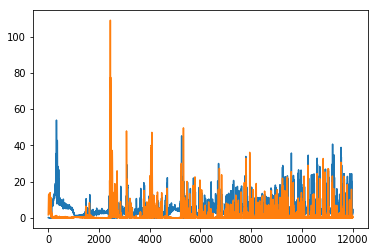

In [19]:
plt.plot(gen_loss_dir)
plt.plot(dis_loss_dir) ## After 25000 Iterations

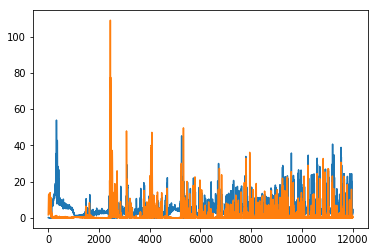

In [20]:
# After 10000 iteartion
plt.plot(gen_loss_dir)
plt.plot(dis_loss_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


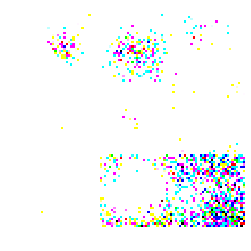

In [22]:
def display_image(images, size):
     n = len(images)
     plt.figure()
     plt.gca().set_axis_off()
     im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
     for i in range(size)])
     plt.imshow(im)
     plt.show()
display_image(fake.reshape(-1, 32, 32, 3), 3)

In [ ]:
display_image(images.reshape(-1, 32, 32, 3), 5)